In [ ]:
!pip install flwr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.1/330.1 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 50.2 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.14.0 requires protobuf<4.21,>=3.20.3, but you have protobuf 4.25.3 which is incompatible.


In [ ]:
!pip install -q flwr[simulation]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 MB 9.5 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive/MyDrive/security_and_privacy')

In [ ]:
!ls

'Datasets&models'   filtered_df.csv   filtered_df_reduced.csv   FL   FL.ipynb


# Flower framework based CNN classifier

In [ ]:
import os
from functools import partial

import flwr as fl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, Input, MaxPooling2D
from tensorflow.keras.models import Model
from FL.model_loader import preprocess_data_CNN, CNN_model
from scipy.stats import laplace

### 1. Data loading and partition

In [ ]:
dataset_path = 'filtered_df_reduced.csv'
df = pd.read_csv(dataset_path)

In [ ]:
#load data
X_train, X_test, y_train, y_test = preprocess_data_CNN(df)

Classification Categories: ['Benign' 'DDoS' 'DoS' 'Mirai' 'Spoofing']
X_train, y_train, X_test, y_test:  (25657, 23) (25657,) (6415, 23) (6415,)


#### Split the data, each client has a unique partition

In [ ]:
NUM_CLIENTS = 5
partition_size = X_train.shape[0] // NUM_CLIENTS

# Define the indices for each client's partition
client_id_to_indices = {}
for client_id in range(NUM_CLIENTS):
    beg_id = client_id * partition_size
    end_id = (client_id + 1) * partition_size
    client_id_to_indices[str(client_id)] = [beg_id, end_id]

# Split the data into partitions for each client
x_split = np.array_split(X_train, NUM_CLIENTS)
y_split = np.array_split(y_train, NUM_CLIENTS)

# Define the proportion of data to use for training
train_split = 0.8

# Create dictionaries to store train and test data for each client
x_trains, y_trains, x_tests, y_tests = {}, {}, {}, {}

# Iterate over each client's partition
for idx, (client_x, client_y) in enumerate(zip(x_split, y_split)):
    train_end_idx = int(train_split * len(client_x))
    x_trains[str(idx)] = client_x[:train_end_idx]
    y_trains[str(idx)] = client_y[:train_end_idx]
    x_tests[str(idx)] = client_x[train_end_idx:]
    y_tests[str(idx)] = client_y[train_end_idx:]

In [ ]:
# Print out the split results
for client_id in range(NUM_CLIENTS):
    print(f"Client {client_id}:")
    print(f"Train data - X: {x_trains[str(client_id)].shape}, y: {y_trains[str(client_id)].shape}")
    print(f"Test data - X: {x_tests[str(client_id)].shape}, y: {y_tests[str(client_id)].shape}")
    print()

Client 0:
Train data - X: (4105, 23, 1), y: (4105,)
Test data - X: (1027, 23, 1), y: (1027,)

Client 1:
Train data - X: (4105, 23, 1), y: (4105,)
Test data - X: (1027, 23, 1), y: (1027,)

Client 2:
Train data - X: (4104, 23, 1), y: (4104,)
Test data - X: (1027, 23, 1), y: (1027,)

Client 3:
Train data - X: (4104, 23, 1), y: (4104,)
Test data - X: (1027, 23, 1), y: (1027,)

Client 4:
Train data - X: (4104, 23, 1), y: (4104,)
Test data - X: (1027, 23, 1), y: (1027,)



### 2. Set up the FL framework:
- A Flower client class with three methods to be implemented
- A function that creates (instantiates) a Flower client
- A strategy that defines the federation algorithm

#### Flower Client

In [ ]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, X_train, y_train, X_test, y_test, epsilon=10):
        self.epsilon = epsilon  # Privacy budget
        self.X_train = self.apply_laplace_noise(X_train)
        self.y_train = y_train  # Assuming labels do not need noise
        self.X_test = self.apply_laplace_noise(X_test)
        self.y_test = y_test
        self.model = CNN_model(self.X_train, self.y_train)

    def apply_laplace_noise(self, data):
        # Sensitivity and scale calculation needs to be adapted based on specific data and context
        sensitivity = 1.0  # This should be set according to your specific use case
        scale = sensitivity / self.epsilon
        noise = laplace.rvs(scale=scale, size=data.shape)
        noisy_data = data + noise
        return noisy_data

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        history = self.model.fit(self.X_train, self.y_train, epochs=2, batch_size=32)
        return self.model.get_weights(), len(self.X_train), {k: v[-1] for k, v in history.history.items()}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        loss, accuracy = self.model.evaluate(self.X_test, self.y_test)
        return loss, len(self.X_test), {"accuracy": accuracy}

#### Client Function
- The only used argument: the client id __(cid)__.   

- In this function, use a map whose keys are cid and values are partitions of the dataset. This map and other parameters can be passed using the partial function from Python’s functools library.

In [ ]:
def create_client(cid, x_trains, y_trains, x_tests, y_tests) -> FlowerClient:
    """Create a Flower client representing a single organization."""
    # Create a single Flower client representing a single organization
    return FlowerClient(x_trains[cid], y_trains[cid], x_tests[cid], y_tests[cid])



client_fnc = partial(
    create_client,
    x_trains=x_trains,
    y_trains=y_trains,
    x_tests=x_tests,
    y_tests=y_tests,
)

#### Aggregate the weights after each running round
- Federated Averaging(FedAvg)

In [ ]:
def weighted_average(metrics):
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]
    return {"accuracy": int(sum(accuracies)) / int(sum(examples))}


# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=1.0,  # Sample 100% of available clients for evaluation
    min_fit_clients=2,  # Never sample less than 2 clients for training
    min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
    min_available_clients=5,  # Wait until all 5 clients are available
    evaluate_metrics_aggregation_fn=weighted_average,
)

### 3. Training

In [ ]:
# Start simulation
history = fl.simulation.start_simulation(
        client_fn=client_fnc,
        num_clients=NUM_CLIENTS,
        config=fl.server.ServerConfig(num_rounds=20),
        strategy=strategy,
        client_resources={"num_cpus": 1, "num_gpus": 0},
        ray_init_args={
            "num_cpus": 1,
            "num_gpus": 0,
            "_system_config": {"automatic_object_spilling_enabled": False},
        },
)

INFO :      Starting Flower simulation, config: num_rounds=20, no round_timeout
INFO:flwr:Starting Flower simulation, config: num_rounds=20, no round_timeout
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-04-14 18:57:06,519	INFO worker.py:1621 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 1.0, 'object_store_memory': 3942039552.0, 'memory': 7884079104.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 1.0, 'object_store_memory': 3942039552.0, 'memory': 7884079104.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize your simulation with Flow

(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2139) 5
(ClientAppActor pid=2139) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.8813 - accuracy: 0.6520
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.4344 - accuracy: 0.8250
(ClientAppActor pid=2139) 5
(ClientAppActor pid=2139) Epoch 1/2


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 3ms/step - loss: 0.9154 - accuracy: 0.6221
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.4489 - accuracy: 0.8114
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2139) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.9072 - accuracy: 0.6292
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.4253 - accuracy: 0.8244
(ClientAppActor pid=2139) 5
(ClientAppActor pid=2139) Epoch 1/2


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 3ms/step - loss: 0.8891 - accuracy: 0.6370
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.4418 - accuracy: 0.8205
(ClientAppActor pid=2139) 5
(ClientAppActor pid=2139) Epoch 1/2


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 3ms/step - loss: 0.9019 - accuracy: 0.6350
(ClientAppActor pid=2139) Epoch 2/2
100/129 [======================>.......] - ETA: 0s - loss: 0.4815 - accuracy: 0.7994


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 1s 5ms/step - loss: 0.4529 - accuracy: 0.8134
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.3034 - accuracy: 0.8987
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.3023 - accuracy: 0.9007
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 3ms/step - loss: 0.2963 - accuracy: 0.8968
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 1s 3ms/step - loss: 0.3029 - accuracy: 0.8978
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 2]
INFO:flwr:[ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 3ms/step - loss: 0.3254 - accuracy: 0.8656
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2139) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.3436 - accuracy: 0.8614
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.2992 - accuracy: 0.8779
(ClientAppActor pid=2139) 5
(ClientAppActor pid=2139) Epoch 1/2


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 3ms/step - loss: 0.3440 - accuracy: 0.8621
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.2945 - accuracy: 0.8784
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2139) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.3322 - accuracy: 0.8614
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.2916 - accuracy: 0.8765
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2139) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.3246 - accuracy: 0.8674
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.2839 - accuracy: 0.8865
(ClientAppActor pid=2139) 5
(ClientAppActor pid=2139) Epoch 1/2


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 3ms/step - loss: 0.3451 - accuracy: 0.8638
(ClientAppActor pid=2139) Epoch 2/2
 65/129 [==============>...............] - ETA: 0s - loss: 0.2971 - accuracy: 0.8803


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 0s 3ms/step - loss: 0.2895 - accuracy: 0.8833


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2139) 5
33/33 [==============================] - 0s 2ms/step - loss: 0.2201 - accuracy: 0.9094
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.2580 - accuracy: 0.8793
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 3ms/step - loss: 0.2308 - accuracy: 0.9017
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.2334 - accuracy: 0.9065
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 3]
INFO:flwr:[ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 3ms/step - loss: 0.2278 - accuracy: 0.9133
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2139) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.2800 - accuracy: 0.8853
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 0.2615 - accuracy: 0.8899
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2139) Epoch 1/2
129/129 [==============================] - 3s 7ms/step - loss: 0.2787 - accuracy: 0.8836
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 1s 8ms/step - loss: 0.2605 - accuracy: 0.8887
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2139) Epoch 1/2
129/129 [==============================] - 4s 13ms/step - loss: 0.2701 - accuracy: 0.8884
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.2642 - accuracy: 0.8923
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2139) Epoch 1/2
129/129 [==============================] - 2s 5ms/step - loss: 0.2903 - accuracy: 0.8784
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 1s 5ms/step - loss: 0.2581 - accuracy: 0.8925
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2139) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.2667 - accuracy: 0.8938
(ClientAppActor pid=2139) Epoch 2/2
102/129 [======================>.......] - ETA: 0s - loss: 0.2497 - accuracy: 0.9023


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 1s 5ms/step - loss: 0.2445 - accuracy: 0.9028
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 1s 2ms/step - loss: 0.2098 - accuracy: 0.9241
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.2266 - accuracy: 0.8987
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.2138 - accuracy: 0.9221
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1944 - accuracy: 0.9260
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 4]
INFO:flwr:[ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.2041 - accuracy: 0.9241
(ClientAppActor pid=2139) 5
(ClientAppActor pid=2139) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.2479 - accuracy: 0.8974
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.2289 - accuracy: 0.9048
(ClientAppActor pid=2139) 5
(ClientAppActor pid=2139) Epoch 1/2


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 3ms/step - loss: 0.2362 - accuracy: 0.9059
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.2294 - accuracy: 0.9079
(ClientAppActor pid=2139) 5
(ClientAppActor pid=2139) Epoch 1/2


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 3ms/step - loss: 0.2630 - accuracy: 0.8891
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.2389 - accuracy: 0.8979
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2139) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.2427 - accuracy: 0.8967
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 1s 4ms/step - loss: 0.2276 - accuracy: 0.9079
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2139) Epoch 1/2
129/129 [==============================] - 2s 5ms/step - loss: 0.2471 - accuracy: 0.8989
(ClientAppActor pid=2139) Epoch 2/2
 90/129 [===================>..........] - ETA: 0s - loss: 0.2349 - accuracy: 0.9014


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 1s 5ms/step - loss: 0.2357 - accuracy: 0.9030


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2139) 5
33/33 [==============================] - 0s 3ms/step - loss: 0.1928 - accuracy: 0.9309
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 3ms/step - loss: 0.2081 - accuracy: 0.9124
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1906 - accuracy: 0.9260
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1857 - accuracy: 0.9318
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 5]
INFO:flwr:[ROUND 5]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 0.1729 - accuracy: 0.9396
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2139) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.2293 - accuracy: 0.9035
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.2092 - accuracy: 0.9172
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2139) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.2224 - accuracy: 0.9133
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.2113 - accuracy: 0.9137
(ClientAppActor pid=2139) 5
(ClientAppActor pid=2139) Epoch 1/2


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 3ms/step - loss: 0.2331 - accuracy: 0.9050
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.2208 - accuracy: 0.9101
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2139) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.2270 - accuracy: 0.9057
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.2105 - accuracy: 0.9196
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2139) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.2103 - accuracy: 0.9206
(ClientAppActor pid=2139) Epoch 2/2
 85/129 [==================>...........] - ETA: 0s - loss: 0.2202 - accuracy: 0.9158


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 1s 6ms/step - loss: 0.2086 - accuracy: 0.9196
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 3ms/step - loss: 0.1910 - accuracy: 0.9133
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 3ms/step - loss: 0.1739 - accuracy: 0.9367
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 3ms/step - loss: 0.1552 - accuracy: 0.9455
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1731 - accuracy: 0.9406
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 6]
INFO:flwr:[ROUND 6]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 0.1773 - accuracy: 0.9357
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2139) Epoch 1/2
129/129 [==============================] - 2s 3ms/step - loss: 0.2172 - accuracy: 0.9179
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.1947 - accuracy: 0.9259
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2139) Epoch 1/2
129/129 [==============================] - 2s 3ms/step - loss: 0.1947 - accuracy: 0.9245
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.1834 - accuracy: 0.9262
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2139) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.1964 - accuracy: 0.9218
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.1874 - accuracy: 0.9264
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2139) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.2128 - accuracy: 0.9098
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 0.2076 - accuracy: 0.9201
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2139) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.2109 - accuracy: 0.9099
(ClientAppActor pid=2139) Epoch 2/2
 96/129 [=====================>........] - ETA: 0s - loss: 0.1934 - accuracy: 0.9225


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 1s 5ms/step - loss: 0.1951 - accuracy: 0.9208
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 3ms/step - loss: 0.1626 - accuracy: 0.9387
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 3ms/step - loss: 0.1563 - accuracy: 0.9455
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 3ms/step - loss: 0.1719 - accuracy: 0.9338
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 3ms/step - loss: 0.1432 - accuracy: 0.9484
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 7]
INFO:flwr:[ROUND 7]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 3ms/step - loss: 0.1600 - accuracy: 0.9435
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2139) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.1877 - accuracy: 0.9315
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.1755 - accuracy: 0.9340
(ClientAppActor pid=2139) 5
(ClientAppActor pid=2139) Epoch 1/2


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 3ms/step - loss: 0.1885 - accuracy: 0.9235
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.1878 - accuracy: 0.9345
(ClientAppActor pid=2139) 5
(ClientAppActor pid=2139) Epoch 1/2


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 3ms/step - loss: 0.1866 - accuracy: 0.9245
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.1866 - accuracy: 0.9284
(ClientAppActor pid=2139) 5
(ClientAppActor pid=2139) Epoch 1/2


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 3ms/step - loss: 0.1945 - accuracy: 0.9211
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.1928 - accuracy: 0.9194
(ClientAppActor pid=2139) 5
(ClientAppActor pid=2139) Epoch 1/2


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 3ms/step - loss: 0.2013 - accuracy: 0.9201
(ClientAppActor pid=2139) Epoch 2/2
 49/129 [==========>...................] - ETA: 0s - loss: 0.2033 - accuracy: 0.9267


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


112/129 [=========================>....] - ETA: 0s - loss: 0.1924 - accuracy: 0.9269


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 0s 3ms/step - loss: 0.1959 - accuracy: 0.9240
(ClientAppActor pid=2139) 5
33/33 [==============================] - 0s 2ms/step - loss: 0.1608 - accuracy: 0.9357
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1300 - accuracy: 0.9533
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1543 - accuracy: 0.9367
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1533 - accuracy: 0.9494
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 8]
INFO:flwr:[ROUND 8]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 3ms/step - loss: 0.1474 - accuracy: 0.9533
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2139) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.1671 - accuracy: 0.9374
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 1s 11ms/step - loss: 0.1671 - accuracy: 0.9347
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2139) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.1646 - accuracy: 0.9376
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.1756 - accuracy: 0.9376
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2139) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.1843 - accuracy: 0.9301
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.1853 - accuracy: 0.9345
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2139) Epoch 1/2
129/129 [==============================] - 2s 3ms/step - loss: 0.1875 - accuracy: 0.9250
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.1841 - accuracy: 0.9264
(ClientAppActor pid=2139) 5
(ClientAppActor pid=2139) Epoch 1/2


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 3ms/step - loss: 0.1868 - accuracy: 0.9308
(ClientAppActor pid=2139) Epoch 2/2
 50/129 [==========>...................] - ETA: 0s - loss: 0.1847 - accuracy: 0.9231


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 0s 3ms/step - loss: 0.1826 - accuracy: 0.9255
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1488 - accuracy: 0.9396
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1270 - accuracy: 0.9503
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1419 - accuracy: 0.9542
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1367 - accuracy: 0.9552
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 9]
INFO:flwr:[ROUND 9]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 3ms/step - loss: 0.1574 - accuracy: 0.9309
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2139) Epoch 1/2
129/129 [==============================] - 2s 5ms/step - loss: 0.1890 - accuracy: 0.9286
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 0.1690 - accuracy: 0.9340
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2139) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.1689 - accuracy: 0.9403
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.1536 - accuracy: 0.9440
(ClientAppActor pid=2139) 5
(ClientAppActor pid=2139) Epoch 1/2


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 3ms/step - loss: 0.1609 - accuracy: 0.9403
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.1548 - accuracy: 0.9405
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2139) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.1837 - accuracy: 0.9288
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.1757 - accuracy: 0.9306
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2139) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.1776 - accuracy: 0.9362
(ClientAppActor pid=2139) Epoch 2/2
 65/129 [==============>...............] - ETA: 0s - loss: 0.1659 - accuracy: 0.9418


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 0s 3ms/step - loss: 0.1638 - accuracy: 0.9410
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1357 - accuracy: 0.9572
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1490 - accuracy: 0.9387
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1454 - accuracy: 0.9426
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1299 - accuracy: 0.9591
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 10]
INFO:flwr:[ROUND 10]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 0.1167 - accuracy: 0.9562
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2139) Epoch 1/2
129/129 [==============================] - 2s 5ms/step - loss: 0.1699 - accuracy: 0.9354
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 1s 5ms/step - loss: 0.1558 - accuracy: 0.9415
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2139) Epoch 1/2
129/129 [==============================] - 2s 5ms/step - loss: 0.1729 - accuracy: 0.9357
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 1s 5ms/step - loss: 0.1668 - accuracy: 0.9315
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2139) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.1649 - accuracy: 0.9396
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.1521 - accuracy: 0.9427
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2139) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.1701 - accuracy: 0.9323
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.1721 - accuracy: 0.9352
(ClientAppActor pid=2139) 5
(ClientAppActor pid=2139) Epoch 1/2


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 3ms/step - loss: 0.1582 - accuracy: 0.9435
(ClientAppActor pid=2139) Epoch 2/2
 51/129 [==========>...................] - ETA: 0s - loss: 0.1482 - accuracy: 0.9510


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


115/129 [=========================>....] - ETA: 0s - loss: 0.1573 - accuracy: 0.9421


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 0s 3ms/step - loss: 0.1586 - accuracy: 0.9410
(ClientAppActor pid=2139) 5
33/33 [==============================] - 0s 2ms/step - loss: 0.1321 - accuracy: 0.9581
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1410 - accuracy: 0.9416
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1260 - accuracy: 0.9620
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1169 - accuracy: 0.9552
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 11]
INFO:flwr:[ROUND 11]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 0.1479 - accuracy: 0.9406
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2139) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.1512 - accuracy: 0.9420
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.1445 - accuracy: 0.9496
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2139) Epoch 1/2
129/129 [==============================] - 2s 5ms/step - loss: 0.1678 - accuracy: 0.9342
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 1s 5ms/step - loss: 0.1681 - accuracy: 0.9376
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2139) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.1594 - accuracy: 0.9374
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 1s 5ms/step - loss: 0.1463 - accuracy: 0.9457
(ClientAppActor pid=2139) 5
(ClientAppActor pid=2139) Epoch 1/2


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 2s 3ms/step - loss: 0.1611 - accuracy: 0.9381
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.1429 - accuracy: 0.9437
(ClientAppActor pid=2139) 5
(ClientAppActor pid=2139) Epoch 1/2


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 3ms/step - loss: 0.1654 - accuracy: 0.9371
(ClientAppActor pid=2139) Epoch 2/2
 77/129 [================>.............] - ETA: 0s - loss: 0.1637 - accuracy: 0.9326


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 0s 3ms/step - loss: 0.1623 - accuracy: 0.9342
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1129 - accuracy: 0.9601
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1199 - accuracy: 0.9620
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1364 - accuracy: 0.9474
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1294 - accuracy: 0.9581
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 12]
INFO:flwr:[ROUND 12]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 0.1417 - accuracy: 0.9406
(ClientAppActor pid=2139) 5
(ClientAppActor pid=2139) Epoch 1/2


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 3ms/step - loss: 0.1493 - accuracy: 0.9425
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.1394 - accuracy: 0.9444
(ClientAppActor pid=2139) 5
(ClientAppActor pid=2139) Epoch 1/2


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 5ms/step - loss: 0.1560 - accuracy: 0.9462
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 0.1463 - accuracy: 0.9496
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2139) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.1602 - accuracy: 0.9452
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 0.1412 - accuracy: 0.9457
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2139) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.1615 - accuracy: 0.9350
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.1588 - accuracy: 0.9386
(ClientAppActor pid=2139) 5
(ClientAppActor pid=2139) Epoch 1/2


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 3ms/step - loss: 0.1714 - accuracy: 0.9340
(ClientAppActor pid=2139) Epoch 2/2
 43/129 [=========>....................] - ETA: 0s - loss: 0.1803 - accuracy: 0.9266


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


106/129 [=======================>......] - ETA: 0s - loss: 0.1717 - accuracy: 0.9375


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 0s 3ms/step - loss: 0.1691 - accuracy: 0.9386
(ClientAppActor pid=2139) 5
33/33 [==============================] - 0s 2ms/step - loss: 0.1125 - accuracy: 0.9552
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1219 - accuracy: 0.9620
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1275 - accuracy: 0.9572
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1385 - accuracy: 0.9426
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 13]
INFO:flwr:[ROUND 13]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 0.1457 - accuracy: 0.9445
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2139) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.1593 - accuracy: 0.9435
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.1413 - accuracy: 0.9486
(ClientAppActor pid=2139) 5
(ClientAppActor pid=2139) Epoch 1/2


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 3ms/step - loss: 0.1641 - accuracy: 0.9386
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 0.1597 - accuracy: 0.9405
(ClientAppActor pid=2139) 5
(ClientAppActor pid=2139) Epoch 1/2


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 3s 9ms/step - loss: 0.1554 - accuracy: 0.9418
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 1s 10ms/step - loss: 0.1411 - accuracy: 0.9520
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2139) Epoch 1/2
129/129 [==============================] - 3s 7ms/step - loss: 0.1421 - accuracy: 0.9474
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 0.1439 - accuracy: 0.9471
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2139) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.1623 - accuracy: 0.9376
(ClientAppActor pid=2139) Epoch 2/2
 65/129 [==============>...............] - ETA: 0s - loss: 0.1443 - accuracy: 0.9423


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 0s 3ms/step - loss: 0.1504 - accuracy: 0.9389
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1250 - accuracy: 0.9630
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1243 - accuracy: 0.9591
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1478 - accuracy: 0.9416
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1105 - accuracy: 0.9581
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 14]
INFO:flwr:[ROUND 14]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 0.1365 - accuracy: 0.9426
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2139) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.1548 - accuracy: 0.9415
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.1365 - accuracy: 0.9474
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2139) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.1467 - accuracy: 0.9483
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.1464 - accuracy: 0.9500
(ClientAppActor pid=2139) 5
(ClientAppActor pid=2139) Epoch 1/2


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 3ms/step - loss: 0.1614 - accuracy: 0.9393
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 0.1539 - accuracy: 0.9418
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2139) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.1609 - accuracy: 0.9345
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 1s 5ms/step - loss: 0.1421 - accuracy: 0.9415
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2139) Epoch 1/2
129/129 [==============================] - 3s 3ms/step - loss: 0.1436 - accuracy: 0.9474
(ClientAppActor pid=2139) Epoch 2/2
 49/129 [==========>...................] - ETA: 0s - loss: 0.1350 - accuracy: 0.9439


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


107/129 [=======================>......] - ETA: 0s - loss: 0.1411 - accuracy: 0.9451


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 0s 3ms/step - loss: 0.1379 - accuracy: 0.9466
(ClientAppActor pid=2139) 5
33/33 [==============================] - 0s 2ms/step - loss: 0.1255 - accuracy: 0.9464
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1205 - accuracy: 0.9542
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1241 - accuracy: 0.9591
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1093 - accuracy: 0.9572
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 15]
INFO:flwr:[ROUND 15]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 0.1427 - accuracy: 0.9445
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2139) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.1504 - accuracy: 0.9452
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.1373 - accuracy: 0.9505
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2139) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.1478 - accuracy: 0.9454
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.1356 - accuracy: 0.9493
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2139) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.1631 - accuracy: 0.9410
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.1634 - accuracy: 0.9357
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2139) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.1435 - accuracy: 0.9481
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 0.1318 - accuracy: 0.9496
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2139) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.1504 - accuracy: 0.9389
(ClientAppActor pid=2139) Epoch 2/2
 64/129 [=============>................] - ETA: 0s - loss: 0.1476 - accuracy: 0.9360


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 0s 3ms/step - loss: 0.1458 - accuracy: 0.9386


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2139) 5
33/33 [==============================] - 0s 2ms/step - loss: 0.1102 - accuracy: 0.9591
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1265 - accuracy: 0.9474
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1482 - accuracy: 0.9435
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1241 - accuracy: 0.9611
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 16]
INFO:flwr:[ROUND 16]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 0.1222 - accuracy: 0.9601
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2139) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.1502 - accuracy: 0.9488
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.1394 - accuracy: 0.9508
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2139) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.1500 - accuracy: 0.9457
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.1365 - accuracy: 0.9488
(ClientAppActor pid=2139) 5
(ClientAppActor pid=2139) Epoch 1/2


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 3ms/step - loss: 0.1327 - accuracy: 0.9471
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.1346 - accuracy: 0.9520
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2139) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.1518 - accuracy: 0.9364
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 0.1440 - accuracy: 0.9410
(ClientAppActor pid=2139) 5
(ClientAppActor pid=2139) Epoch 1/2


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 2s 6ms/step - loss: 0.1638 - accuracy: 0.9381
(ClientAppActor pid=2139) Epoch 2/2
 79/129 [=================>............] - ETA: 0s - loss: 0.1515 - accuracy: 0.9407


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 1s 6ms/step - loss: 0.1580 - accuracy: 0.9391
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 1s 3ms/step - loss: 0.1165 - accuracy: 0.9620
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1197 - accuracy: 0.9611
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1144 - accuracy: 0.9552
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1247 - accuracy: 0.9455
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 17]
INFO:flwr:[ROUND 17]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 0.1481 - accuracy: 0.9445
(ClientAppActor pid=2139) 5
(ClientAppActor pid=2139) Epoch 1/2


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 3ms/step - loss: 0.1577 - accuracy: 0.9420
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.1421 - accuracy: 0.9459
(ClientAppActor pid=2139) 5
(ClientAppActor pid=2139) Epoch 1/2


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 3ms/step - loss: 0.1510 - accuracy: 0.9437
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.1541 - accuracy: 0.9391
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2139) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.1297 - accuracy: 0.9479
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.1363 - accuracy: 0.9559
(ClientAppActor pid=2139) 5
(ClientAppActor pid=2139) Epoch 1/2


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 3ms/step - loss: 0.1473 - accuracy: 0.9471
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.1386 - accuracy: 0.9486
(ClientAppActor pid=2139) 5
(ClientAppActor pid=2139) Epoch 1/2


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 2s 5ms/step - loss: 0.1443 - accuracy: 0.9491
(ClientAppActor pid=2139) Epoch 2/2
 88/129 [===================>..........] - ETA: 0s - loss: 0.1349 - accuracy: 0.9524


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 1s 6ms/step - loss: 0.1331 - accuracy: 0.9530
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 3ms/step - loss: 0.1014 - accuracy: 0.9620
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 3ms/step - loss: 0.1378 - accuracy: 0.9474
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 3ms/step - loss: 0.1209 - accuracy: 0.9494
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 3ms/step - loss: 0.1175 - accuracy: 0.9640
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 18]
INFO:flwr:[ROUND 18]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 0.1116 - accuracy: 0.9611
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2139) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.1506 - accuracy: 0.9396
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.1457 - accuracy: 0.9396
(ClientAppActor pid=2139) 5
(ClientAppActor pid=2139) Epoch 1/2


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 3ms/step - loss: 0.1503 - accuracy: 0.9435
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.1517 - accuracy: 0.9435
(ClientAppActor pid=2139) 5
(ClientAppActor pid=2139) Epoch 1/2


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 2s 3ms/step - loss: 0.1361 - accuracy: 0.9484
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.1406 - accuracy: 0.9479
(ClientAppActor pid=2139) 5
(ClientAppActor pid=2139) Epoch 1/2


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 3ms/step - loss: 0.1427 - accuracy: 0.9459
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.1345 - accuracy: 0.9486
(ClientAppActor pid=2139) 5
(ClientAppActor pid=2139) Epoch 1/2


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 2s 5ms/step - loss: 0.1372 - accuracy: 0.9527
(ClientAppActor pid=2139) Epoch 2/2
 72/129 [===============>..............] - ETA: 0s - loss: 0.1290 - accuracy: 0.9523


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


129/129 [==============================] - 1s 6ms/step - loss: 0.1244 - accuracy: 0.9552


INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1170 - accuracy: 0.9620
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 3ms/step - loss: 0.1219 - accuracy: 0.9464
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 1s 3ms/step - loss: 0.1189 - accuracy: 0.9581
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 3ms/step - loss: 0.1166 - accuracy: 0.9591
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 19]
INFO:flwr:[ROUND 19]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 0.1496 - accuracy: 0.9445
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2139) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.1435 - accuracy: 0.9457
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.1324 - accuracy: 0.9505
(ClientAppActor pid=2139) 5
(ClientAppActor pid=2139) Epoch 1/2


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 3ms/step - loss: 0.1334 - accuracy: 0.9476
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.1353 - accuracy: 0.9498
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2139) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.1523 - accuracy: 0.9352
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.1493 - accuracy: 0.9435
(ClientAppActor pid=2139) 5
(ClientAppActor pid=2139) Epoch 1/2


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 3ms/step - loss: 0.1479 - accuracy: 0.9423
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.1459 - accuracy: 0.9459
(ClientAppActor pid=2139) 5
(ClientAppActor pid=2139) Epoch 1/2


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 3ms/step - loss: 0.1427 - accuracy: 0.9479
(ClientAppActor pid=2139) Epoch 2/2
 50/129 [==========>...................] - ETA: 0s - loss: 0.1265 - accuracy: 0.9513


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 0s 3ms/step - loss: 0.1276 - accuracy: 0.9508
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 3ms/step - loss: 0.1048 - accuracy: 0.9572
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 3ms/step - loss: 0.1188 - accuracy: 0.9523
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 3ms/step - loss: 0.1416 - accuracy: 0.9474
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1136 - accuracy: 0.9630
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 20]
INFO:flwr:[ROUND 20]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 0.1090 - accuracy: 0.9640
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2139) Epoch 1/2
129/129 [==============================] - 2s 3ms/step - loss: 0.1425 - accuracy: 0.9408
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.1437 - accuracy: 0.9454
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2139) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.1278 - accuracy: 0.9491
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.1355 - accuracy: 0.9522
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2139) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.1533 - accuracy: 0.9410
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.1448 - accuracy: 0.9405
(ClientAppActor pid=2139) 5
(ClientAppActor pid=2139) Epoch 1/2


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 3ms/step - loss: 0.1373 - accuracy: 0.9520
(ClientAppActor pid=2139) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 0.1307 - accuracy: 0.9542
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2139) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.1344 - accuracy: 0.9503
(ClientAppActor pid=2139) Epoch 2/2
 65/129 [==============>...............] - ETA: 0s - loss: 0.1323 - accuracy: 0.9495


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 0s 3ms/step - loss: 0.1292 - accuracy: 0.9510
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1191 - accuracy: 0.9591
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1179 - accuracy: 0.9620
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 3ms/step - loss: 0.1213 - accuracy: 0.9494
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 3ms/step - loss: 0.1181 - accuracy: 0.9552
(ClientAppActor pid=2139) 5


(ClientAppActor pid=2139) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [SUMMARY]
INFO:flwr:[SUMMARY]
INFO :      Run finished 20 rounds in 282.10s
INFO:flwr:Run finished 20 rounds in 282.10s
INFO :      History (loss, distributed):
INFO:flwr:History (loss, distributed):
INFO :      	('\tround 1: 0.3060316264629364\n'
INFO:flwr:	('\tround 1: 0.3060316264629364\n'
INFO :      	 '\tround 2: 0.23400136232376098\n'
INFO:flwr:	 '\tround 2: 0.23400136232376098\n'
INFO :      	 '\tround 3: 0.2097300499677658\n'
INFO:flwr:	 '\tround 3: 0.2097300499677658\n'
INFO :      	 '\tround 4: 0.1900450050830841\n'
INFO:flwr:	 '\tround 4: 0.1900450050830841\n'
INFO :      	 '\t

33/33 [==============================] - 0s 3ms/step - loss: 0.1498 - accuracy: 0.9426


history.losses_distributed = [(1, 0.3060316264629364), (2, 0.23400136232376098), (3, 0.2097300499677658), (4, 0.1900450050830841), (5, 0.17411135733127595), (6, 0.15880180895328522), (7, 0.14915922284126282), (8, 0.14236798584461213), (9, 0.1353333920240402), (10, 0.13280605673789977), (11, 0.1280545711517334), (12, 0.12920491248369217), (13, 0.12882526963949203), (14, 0.1244401529431343), (15, 0.12625730633735657), (16, 0.12468132376670837), (17, 0.11784752011299134), (18, 0.12479237169027328), (19, 0.11755129992961884), (20, 0.12523283511400224)]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


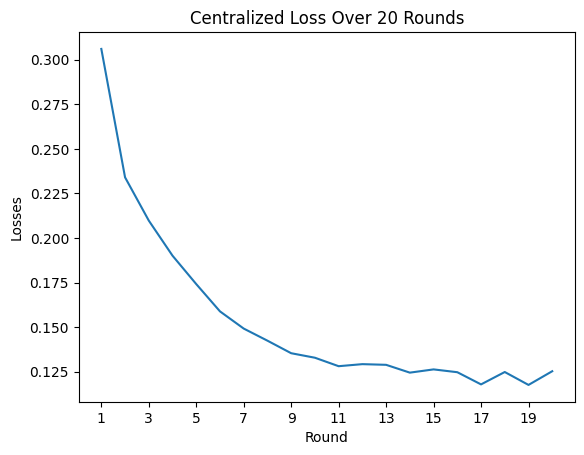

In [ ]:
print(f"{history.losses_distributed = }")

# Extract rounds and losses from the distributed losses
loss_centralised = history.losses_distributed
rounds = [int(data[0]) for data in loss_centralised]  # Cast rounds to integers
losses = [data[1] for data in loss_centralised]

# Plot the centralized loss over rounds
plt.plot(rounds, losses)
plt.ylabel("Losses")
plt.xlabel("Round")
plt.title(f'Centralized Loss Over {max(rounds)} Rounds')
plt.xticks(np.arange(min(rounds), max(rounds)+1, 2))
plt.show()


history.metrics_distributed= {'accuracy': [(1, 0.8917234664070107), (2, 0.9020447906523856), (3, 0.9187925998052581), (4, 0.9279454722492697), (5, 0.9343719571567672), (6, 0.9417721518987342), (7, 0.9456669912366115), (8, 0.9458617332035053), (9, 0.950730282375852), (10, 0.9515092502434275), (11, 0.9534566699123661), (12, 0.952288218111003), (13, 0.9528724440116845), (14, 0.9520934761441091), (15, 0.9540408958130477), (16, 0.95365141187926), (17, 0.9567672833495618), (18, 0.9540408958130477), (19, 0.9567672833495618), (20, 0.95365141187926)]}


Text(0.5, 1.0, 'Centralized Accuracy Over 20 Rounds')

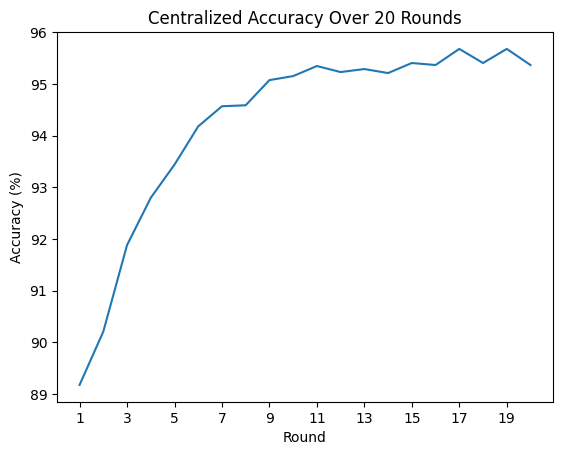

In [ ]:
print(f"{history.metrics_distributed= }")

global_accuracy_centralised = history.metrics_distributed ["accuracy"]
round = [data[0] for data in global_accuracy_centralised]
acc = [100.0 * data[1] for data in global_accuracy_centralised]
plt.plot(round, acc)
plt.ylabel("Accuracy (%)")
plt.xlabel("Round")
plt.xticks(np.arange(min(rounds), max(rounds), 2))
plt.title(f"Centralized Accuracy Over {max(rounds)} Rounds")

## Test with different ε values

In [ ]:
import matplotlib.pyplot as plt
from functools import partial

# Assuming the necessary imports and client setup as per your previous code snippets
def run_simulation(epsilon):
    # Function to initialize clients with varying epsilon or no privacy intervention
    def create_client_with_epsilon(cid, x_trains, y_trains, x_tests, y_tests):
        return FlowerClient(x_trains[cid], y_trains[cid], x_tests[cid], y_tests[cid], epsilon=epsilon)

    client_fnc = partial(
        create_client_with_epsilon,
        x_trains=x_trains,
        y_trains=y_trains,
        x_tests=x_tests,
        y_tests=y_tests,
    )

    history = fl.simulation.start_simulation(
        client_fn=client_fnc,
        num_clients=NUM_CLIENTS,
        config=fl.server.ServerConfig(num_rounds=15),
        strategy=strategy,
        client_resources={"num_cpus": 1, "num_gpus": 0},
        ray_init_args={
            "num_cpus": 1,
            "num_gpus": 0,
            "_system_config": {"automatic_object_spilling_enabled": False},
        },
    )
    return history

epsilons = [0.1, 1, 5, 10, float('inf')]
all_histories = {}

for eps in epsilons:
    all_histories[eps] = run_simulation(eps)

INFO :      Starting Flower simulation, config: num_rounds=15, no round_timeout
INFO:flwr:Starting Flower simulation, config: num_rounds=15, no round_timeout
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-04-14 19:30:24,481	INFO worker.py:1621 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 1.0, 'object_store_memory': 3850448486.0, 'memory': 7700896974.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 1.0, 'object_store_memory': 3850448486.0, 'memory': 7700896974.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize your simulation with Flow

(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=20889) 5
(ClientAppActor pid=20889) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 1.7031 - accuracy: 0.2382
(ClientAppActor pid=20889) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 1.5728 - accuracy: 0.2670
(ClientAppActor pid=20889) 5
(ClientAppActor pid=20889) Epoch 1/2


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 3ms/step - loss: 1.7006 - accuracy: 0.2402
(ClientAppActor pid=20889) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 1.5828 - accuracy: 0.2758
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=20889) Epoch 1/2
129/129 [==============================] - 2s 5ms/step - loss: 1.7166 - accuracy: 0.2410
(ClientAppActor pid=20889) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 1.5818 - accuracy: 0.2785
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=20889) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 1.7153 - accuracy: 0.2293
(ClientAppActor pid=20889) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 1.5775 - accuracy: 0.2646
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=20889) Epoch 1/2
129/129 [==============================] - 2s 5ms/step - loss: 1.7085 - accuracy: 0.2403
(ClientAppActor pid=20889) Epoch 2/2
 33/129 [======>.......................] - ETA: 0s - loss: 1.5860 - accuracy: 0.2311


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


 97/129 [=====================>........] - ETA: 0s - loss: 1.5824 - accuracy: 0.2555


INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 0s 3ms/step - loss: 1.5858 - accuracy: 0.2578
(ClientAppActor pid=20889) 5
33/33 [==============================] - 0s 2ms/step - loss: 1.5723 - accuracy: 0.2785
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 1.5633 - accuracy: 0.2960
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 1.5730 - accuracy: 0.2707
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 1.5651 - accuracy: 0.2902
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 2]
INFO:flwr:[ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 1.5785 - accuracy: 0.2512
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=20889) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 1.5839 - accuracy: 0.2709
(ClientAppActor pid=20889) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 1.5709 - accuracy: 0.2806
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=20889) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 1.5871 - accuracy: 0.2578
(ClientAppActor pid=20889) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 1.5762 - accuracy: 0.2597
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=20889) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 1.5809 - accuracy: 0.2739
(ClientAppActor pid=20889) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 1.5710 - accuracy: 0.2778
(ClientAppActor pid=20889) 5
(ClientAppActor pid=20889) Epoch 1/2


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 5ms/step - loss: 1.5740 - accuracy: 0.2650
(ClientAppActor pid=20889) Epoch 2/2
129/129 [==============================] - 1s 5ms/step - loss: 1.5653 - accuracy: 0.2658
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=20889) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 1.5728 - accuracy: 0.2705
(ClientAppActor pid=20889) Epoch 2/2
107/129 [=======================>......] - ETA: 0s - loss: 1.5674 - accuracy: 0.2728


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 1s 6ms/step - loss: 1.5674 - accuracy: 0.2722
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 3ms/step - loss: 1.5578 - accuracy: 0.2941
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 1.5760 - accuracy: 0.2522
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 1.5588 - accuracy: 0.2882
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 1.5711 - accuracy: 0.2707
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 3]
INFO:flwr:[ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 1.5677 - accuracy: 0.2765
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=20889) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 1.5718 - accuracy: 0.2797
(ClientAppActor pid=20889) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 1.5660 - accuracy: 0.2790
(ClientAppActor pid=20889) 5
(ClientAppActor pid=20889) Epoch 1/2


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 3ms/step - loss: 1.5640 - accuracy: 0.2705
(ClientAppActor pid=20889) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 1.5615 - accuracy: 0.2712
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=20889) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 1.5733 - accuracy: 0.2585
(ClientAppActor pid=20889) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 1.5711 - accuracy: 0.2617
(ClientAppActor pid=20889) 5
(ClientAppActor pid=20889) Epoch 1/2


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 3ms/step - loss: 1.5675 - accuracy: 0.2697
(ClientAppActor pid=20889) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 1.5632 - accuracy: 0.2672
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=20889) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 1.5668 - accuracy: 0.2792
(ClientAppActor pid=20889) Epoch 2/2
 83/129 [==================>...........] - ETA: 0s - loss: 1.5667 - accuracy: 0.2820


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 1s 5ms/step - loss: 1.5682 - accuracy: 0.2760
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 1s 3ms/step - loss: 1.5577 - accuracy: 0.2882
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 3ms/step - loss: 1.5712 - accuracy: 0.2707
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 1.5665 - accuracy: 0.2765
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 1.5752 - accuracy: 0.2522
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 4]
INFO:flwr:[ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 1.5577 - accuracy: 0.2941
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=20889) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 1.5571 - accuracy: 0.2724
(ClientAppActor pid=20889) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 1.5541 - accuracy: 0.2731
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=20889) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 1.5607 - accuracy: 0.2699
(ClientAppActor pid=20889) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 1.5589 - accuracy: 0.2697
(ClientAppActor pid=20889) 5
(ClientAppActor pid=20889) Epoch 1/2


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 3ms/step - loss: 1.5710 - accuracy: 0.2605
(ClientAppActor pid=20889) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 1.5674 - accuracy: 0.2605
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=20889) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 1.5646 - accuracy: 0.2790
(ClientAppActor pid=20889) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 1.5632 - accuracy: 0.2797
(ClientAppActor pid=20889) 5
(ClientAppActor pid=20889) Epoch 1/2


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 2s 6ms/step - loss: 1.5632 - accuracy: 0.2784
(ClientAppActor pid=20889) Epoch 2/2
 82/129 [==================>...........] - ETA: 0s - loss: 1.5603 - accuracy: 0.2843


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 1s 5ms/step - loss: 1.5603 - accuracy: 0.2787
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 3ms/step - loss: 1.5641 - accuracy: 0.2765
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 3ms/step - loss: 1.5534 - accuracy: 0.2941
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 3ms/step - loss: 1.5696 - accuracy: 0.2707
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 3ms/step - loss: 1.5745 - accuracy: 0.2522
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 5]
INFO:flwr:[ROUND 5]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 1.5531 - accuracy: 0.2882
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=20889) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 1.5590 - accuracy: 0.2697
(ClientAppActor pid=20889) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 1.5565 - accuracy: 0.2699
(ClientAppActor pid=20889) 5
(ClientAppActor pid=20889) Epoch 1/2


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 3ms/step - loss: 1.5665 - accuracy: 0.2605
(ClientAppActor pid=20889) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 1.5647 - accuracy: 0.2634
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=20889) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 1.5621 - accuracy: 0.2799
(ClientAppActor pid=20889) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 1.5589 - accuracy: 0.2799
(ClientAppActor pid=20889) 5
(ClientAppActor pid=20889) Epoch 1/2


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 3ms/step - loss: 1.5606 - accuracy: 0.2800
(ClientAppActor pid=20889) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 1.5577 - accuracy: 0.2802
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=20889) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 1.5553 - accuracy: 0.2724
(ClientAppActor pid=20889) Epoch 2/2
 80/129 [=================>............] - ETA: 0s - loss: 1.5454 - accuracy: 0.2754


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 0s 3ms/step - loss: 1.5489 - accuracy: 0.2727
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 3ms/step - loss: 1.5670 - accuracy: 0.2707
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 3ms/step - loss: 1.5616 - accuracy: 0.2765
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 3ms/step - loss: 1.5482 - accuracy: 0.2882
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 1.5737 - accuracy: 0.2522
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 6]
INFO:flwr:[ROUND 6]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 3ms/step - loss: 1.5479 - accuracy: 0.2941
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `
(ClientAppActor pid=20889) NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=20889) Epoch 1/2
129/129 [==============================] - 2s 3ms/step - loss: 1.5561 - accuracy: 0.2697
(ClientAppActor pid=20889) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 1.5571 - accuracy: 0.2699
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=20889) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 1.5505 - accuracy: 0.2724
(ClientAppActor pid=20889) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 1.5500 - accuracy: 0.2724
(ClientAppActor pid=20889) 5
(ClientAppActor pid=20889) Epoch 1/2


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 4ms/step - loss: 1.5581 - accuracy: 0.2792
(ClientAppActor pid=20889) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 1.5560 - accuracy: 0.2797
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=20889) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 1.5599 - accuracy: 0.2797
(ClientAppActor pid=20889) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 1.5573 - accuracy: 0.2788
(ClientAppActor pid=20889) 5
(ClientAppActor pid=20889) Epoch 1/2


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 3ms/step - loss: 1.5675 - accuracy: 0.2600
(ClientAppActor pid=20889) Epoch 2/2
 45/129 [=========>....................] - ETA: 0s - loss: 1.5661 - accuracy: 0.2576


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


106/129 [=======================>......] - ETA: 0s - loss: 1.5589 - accuracy: 0.2650


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 0s 3ms/step - loss: 1.5635 - accuracy: 0.2612
(ClientAppActor pid=20889) 5
33/33 [==============================] - 0s 2ms/step - loss: 1.5629 - accuracy: 0.2765
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 3ms/step - loss: 1.5692 - accuracy: 0.2707
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 3ms/step - loss: 1.5736 - accuracy: 0.2522
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 3ms/step - loss: 1.5499 - accuracy: 0.2882
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 7]
INFO:flwr:[ROUND 7]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 1.5505 - accuracy: 0.2941
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=20889) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 1.5578 - accuracy: 0.2702
(ClientAppActor pid=20889) Epoch 2/2
129/129 [==============================] - 1s 4ms/step - loss: 1.5574 - accuracy: 0.2702
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=20889) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 1.5597 - accuracy: 0.2763
(ClientAppActor pid=20889) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 1.5571 - accuracy: 0.2795
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=20889) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 1.5536 - accuracy: 0.2724
(ClientAppActor pid=20889) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 1.5501 - accuracy: 0.2719
(ClientAppActor pid=20889) 5
(ClientAppActor pid=20889) Epoch 1/2


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 3ms/step - loss: 1.5561 - accuracy: 0.2784
(ClientAppActor pid=20889) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 1.5565 - accuracy: 0.2784
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=20889) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 1.5647 - accuracy: 0.2607
(ClientAppActor pid=20889) Epoch 2/2
 48/129 [==========>...................] - ETA: 0s - loss: 1.5599 - accuracy: 0.2695


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


111/129 [========================>.....] - ETA: 0s - loss: 1.5648 - accuracy: 0.2652


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 0s 3ms/step - loss: 1.5665 - accuracy: 0.2610
(ClientAppActor pid=20889) 5
33/33 [==============================] - 0s 2ms/step - loss: 1.5630 - accuracy: 0.2765
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 1.5505 - accuracy: 0.2941
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 1.5696 - accuracy: 0.2707
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 1.5499 - accuracy: 0.2882
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 8]
INFO:flwr:[ROUND 8]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 3ms/step - loss: 1.5743 - accuracy: 0.2522
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=20889) Epoch 1/2
129/129 [==============================] - 2s 5ms/step - loss: 1.5557 - accuracy: 0.2697
(ClientAppActor pid=20889) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 1.5534 - accuracy: 0.2702
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=20889) Epoch 1/2
129/129 [==============================] - 2s 3ms/step - loss: 1.5584 - accuracy: 0.2800
(ClientAppActor pid=20889) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 1.5582 - accuracy: 0.2795
(ClientAppActor pid=20889) 5
(ClientAppActor pid=20889) Epoch 1/2


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 3ms/step - loss: 1.5492 - accuracy: 0.2724
(ClientAppActor pid=20889) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 1.5473 - accuracy: 0.2722
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=20889) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 1.5553 - accuracy: 0.2792
(ClientAppActor pid=20889) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 1.5546 - accuracy: 0.2789
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=20889) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 1.5647 - accuracy: 0.2605
(ClientAppActor pid=20889) Epoch 2/2
 48/129 [==========>...................] - ETA: 0s - loss: 1.5623 - accuracy: 0.2650


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


110/129 [========================>.....] - ETA: 0s - loss: 1.5664 - accuracy: 0.2597


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 0s 3ms/step - loss: 1.5647 - accuracy: 0.2605
(ClientAppActor pid=20889) 5
33/33 [==============================] - 0s 2ms/step - loss: 1.5691 - accuracy: 0.2707
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 1.5743 - accuracy: 0.2522
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 1.5478 - accuracy: 0.2882
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 1.5486 - accuracy: 0.2941
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 9]
INFO:flwr:[ROUND 9]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 1.5616 - accuracy: 0.2765
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=20889) Epoch 1/2
129/129 [==============================] - 2s 5ms/step - loss: 1.5500 - accuracy: 0.2724
(ClientAppActor pid=20889) Epoch 2/2
129/129 [==============================] - 1s 5ms/step - loss: 1.5493 - accuracy: 0.2719
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=20889) Epoch 1/2
129/129 [==============================] - 2s 5ms/step - loss: 1.5565 - accuracy: 0.2699
(ClientAppActor pid=20889) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 1.5546 - accuracy: 0.2697
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=20889) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 1.5569 - accuracy: 0.2794
(ClientAppActor pid=20889) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 1.5559 - accuracy: 0.2787
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=20889) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 1.5647 - accuracy: 0.2600
(ClientAppActor pid=20889) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 1.5647 - accuracy: 0.2610
(ClientAppActor pid=20889) 5
(ClientAppActor pid=20889) Epoch 1/2


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 3ms/step - loss: 1.5598 - accuracy: 0.2792
(ClientAppActor pid=20889) Epoch 2/2
 50/129 [==========>...................] - ETA: 0s - loss: 1.5575 - accuracy: 0.2750


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 0s 3ms/step - loss: 1.5586 - accuracy: 0.2800
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 1.5694 - accuracy: 0.2707
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 1.5487 - accuracy: 0.2941
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 1.5754 - accuracy: 0.2522
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 1.5475 - accuracy: 0.2882
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 10]
INFO:flwr:[ROUND 10]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 1.5621 - accuracy: 0.2765
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=20889) Epoch 1/2
129/129 [==============================] - 1s 5ms/step - loss: 1.5550 - accuracy: 0.2699
(ClientAppActor pid=20889) Epoch 2/2
129/129 [==============================] - 1s 5ms/step - loss: 1.5540 - accuracy: 0.2699
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=20889) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 1.5503 - accuracy: 0.2724
(ClientAppActor pid=20889) Epoch 2/2
129/129 [==============================] - 1s 5ms/step - loss: 1.5470 - accuracy: 0.2724
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=20889) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 1.5530 - accuracy: 0.2792
(ClientAppActor pid=20889) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 1.5547 - accuracy: 0.2792
(ClientAppActor pid=20889) 5
(ClientAppActor pid=20889) Epoch 1/2


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 3ms/step - loss: 1.5599 - accuracy: 0.2800
(ClientAppActor pid=20889) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 1.5598 - accuracy: 0.2792
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=20889) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 1.5646 - accuracy: 0.2605
(ClientAppActor pid=20889) Epoch 2/2
 90/129 [===================>..........] - ETA: 0s - loss: 1.5580 - accuracy: 0.2639


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 0s 3ms/step - loss: 1.5641 - accuracy: 0.2607
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 1.5687 - accuracy: 0.2707
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 1.5744 - accuracy: 0.2522
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 1.5614 - accuracy: 0.2765
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 1.5472 - accuracy: 0.2882
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 11]
INFO:flwr:[ROUND 11]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 1.5485 - accuracy: 0.2941
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=20889) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 1.5627 - accuracy: 0.2610
(ClientAppActor pid=20889) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 1.5609 - accuracy: 0.2610
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=20889) Epoch 1/2
129/129 [==============================] - 2s 5ms/step - loss: 1.5535 - accuracy: 0.2800
(ClientAppActor pid=20889) Epoch 2/2
129/129 [==============================] - 1s 5ms/step - loss: 1.5541 - accuracy: 0.2800
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=20889) Epoch 1/2
129/129 [==============================] - 2s 3ms/step - loss: 1.5564 - accuracy: 0.2692
(ClientAppActor pid=20889) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 1.5531 - accuracy: 0.2692
(ClientAppActor pid=20889) 5
(ClientAppActor pid=20889) Epoch 1/2


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 4ms/step - loss: 1.5471 - accuracy: 0.2724
(ClientAppActor pid=20889) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 1.5463 - accuracy: 0.2724
(ClientAppActor pid=20889) 5
(ClientAppActor pid=20889) Epoch 1/2


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 3ms/step - loss: 1.5553 - accuracy: 0.2799
(ClientAppActor pid=20889) Epoch 2/2
 33/129 [======>.......................] - ETA: 0s - loss: 1.5600 - accuracy: 0.2727


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


 97/129 [=====================>........] - ETA: 0s - loss: 1.5513 - accuracy: 0.2832


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 0s 3ms/step - loss: 1.5536 - accuracy: 0.2792
(ClientAppActor pid=20889) 5
33/33 [==============================] - 0s 2ms/step - loss: 1.5750 - accuracy: 0.2522
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 1.5613 - accuracy: 0.2765
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 1.5682 - accuracy: 0.2707
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 1.5464 - accuracy: 0.2882
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 12]
INFO:flwr:[ROUND 12]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 1.5473 - accuracy: 0.2941
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=20889) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 1.5564 - accuracy: 0.2797
(ClientAppActor pid=20889) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 1.5563 - accuracy: 0.2800
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=20889) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 1.5569 - accuracy: 0.2689
(ClientAppActor pid=20889) Epoch 2/2
129/129 [==============================] - 1s 5ms/step - loss: 1.5541 - accuracy: 0.2699
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=20889) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 1.5547 - accuracy: 0.2792
(ClientAppActor pid=20889) Epoch 2/2
129/129 [==============================] - 1s 4ms/step - loss: 1.5544 - accuracy: 0.2797
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=20889) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 1.5641 - accuracy: 0.2602
(ClientAppActor pid=20889) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 1.5623 - accuracy: 0.2607
(ClientAppActor pid=20889) 5
(ClientAppActor pid=20889) Epoch 1/2


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 3ms/step - loss: 1.5493 - accuracy: 0.2729
(ClientAppActor pid=20889) Epoch 2/2
 45/129 [=========>....................] - ETA: 0s - loss: 1.5493 - accuracy: 0.2681


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


107/129 [=======================>......] - ETA: 0s - loss: 1.5466 - accuracy: 0.2702


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 0s 3ms/step - loss: 1.5457 - accuracy: 0.2710
(ClientAppActor pid=20889) 5
33/33 [==============================] - 0s 2ms/step - loss: 1.5679 - accuracy: 0.2707
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 1.5599 - accuracy: 0.2765
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 1.5746 - accuracy: 0.2522
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 1.5460 - accuracy: 0.2941
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 13]
INFO:flwr:[ROUND 13]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 1.5460 - accuracy: 0.2882


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=20889) 5
(ClientAppActor pid=20889) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 1.5556 - accuracy: 0.2805
(ClientAppActor pid=20889) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 1.5537 - accuracy: 0.2800
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=20889) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 1.5552 - accuracy: 0.2797
(ClientAppActor pid=20889) Epoch 2/2
129/129 [==============================] - 1s 5ms/step - loss: 1.5520 - accuracy: 0.2792
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=20889) Epoch 1/2
129/129 [==============================] - 2s 5ms/step - loss: 1.5642 - accuracy: 0.2607
(ClientAppActor pid=20889) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 1.5633 - accuracy: 0.2607
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=20889) Epoch 1/2
129/129 [==============================] - 2s 3ms/step - loss: 1.5456 - accuracy: 0.2722
(ClientAppActor pid=20889) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 1.5457 - accuracy: 0.2724
(ClientAppActor pid=20889) 5
(ClientAppActor pid=20889) Epoch 1/2


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 3ms/step - loss: 1.5552 - accuracy: 0.2689
(ClientAppActor pid=20889) Epoch 2/2
 48/129 [==========>...................] - ETA: 0s - loss: 1.5523 - accuracy: 0.2819


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


112/129 [=========================>....] - ETA: 0s - loss: 1.5531 - accuracy: 0.2715


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 0s 3ms/step - loss: 1.5533 - accuracy: 0.2689
(ClientAppActor pid=20889) 5
33/33 [==============================] - 0s 2ms/step - loss: 1.5607 - accuracy: 0.2765
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 1.5459 - accuracy: 0.2882
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 1.5474 - accuracy: 0.2941
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 1.5680 - accuracy: 0.2707
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 14]
INFO:flwr:[ROUND 14]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 1.5751 - accuracy: 0.2522
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=20889) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 1.5478 - accuracy: 0.2724
(ClientAppActor pid=20889) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 1.5441 - accuracy: 0.2722
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=20889) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 1.5547 - accuracy: 0.2789
(ClientAppActor pid=20889) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 1.5543 - accuracy: 0.2797
(ClientAppActor pid=20889) 5
(ClientAppActor pid=20889) Epoch 1/2


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 2s 5ms/step - loss: 1.5547 - accuracy: 0.2797
(ClientAppActor pid=20889) Epoch 2/2
129/129 [==============================] - 1s 5ms/step - loss: 1.5542 - accuracy: 0.2800
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=20889) Epoch 1/2
129/129 [==============================] - 3s 4ms/step - loss: 1.5651 - accuracy: 0.2597
(ClientAppActor pid=20889) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 1.5611 - accuracy: 0.2607
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=20889) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 1.5523 - accuracy: 0.2697
(ClientAppActor pid=20889) Epoch 2/2
 90/129 [===================>..........] - ETA: 0s - loss: 1.5501 - accuracy: 0.2677


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 0s 3ms/step - loss: 1.5531 - accuracy: 0.2697
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 1.5596 - accuracy: 0.2765
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 1.5674 - accuracy: 0.2707
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 1.5455 - accuracy: 0.2882
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 1.5471 - accuracy: 0.2941
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 15]
INFO:flwr:[ROUND 15]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 1.5742 - accuracy: 0.2522
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=20889) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 1.5529 - accuracy: 0.2789
(ClientAppActor pid=20889) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 1.5514 - accuracy: 0.2787
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=20889) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 1.5555 - accuracy: 0.2802
(ClientAppActor pid=20889) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 1.5534 - accuracy: 0.2797
(ClientAppActor pid=20889) 5
(ClientAppActor pid=20889) Epoch 1/2


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 2s 6ms/step - loss: 1.5621 - accuracy: 0.2605
(ClientAppActor pid=20889) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 1.5615 - accuracy: 0.2597
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=20889) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 1.5479 - accuracy: 0.2727
(ClientAppActor pid=20889) Epoch 2/2
129/129 [==============================] - 1s 5ms/step - loss: 1.5425 - accuracy: 0.2722
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=20889) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 1.5541 - accuracy: 0.2699
(ClientAppActor pid=20889) Epoch 2/2
 66/129 [==============>...............] - ETA: 0s - loss: 1.5530 - accuracy: 0.2770


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


109/129 [========================>.....] - ETA: 0s - loss: 1.5538 - accuracy: 0.2706


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 0s 3ms/step - loss: 1.5551 - accuracy: 0.2680
(ClientAppActor pid=20889) 5
33/33 [==============================] - 0s 2ms/step - loss: 1.5478 - accuracy: 0.2941
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 1.5616 - accuracy: 0.2765
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 1.5674 - accuracy: 0.2707
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 1.5750 - accuracy: 0.2522
(ClientAppActor pid=20889) 5


(ClientAppActor pid=20889) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [SUMMARY]
INFO:flwr:[SUMMARY]
INFO :      Run finished 15 rounds in 209.20s
INFO:flwr:Run finished 15 rounds in 209.20s
INFO :      History (loss, distributed):
INFO:flwr:History (loss, distributed):
INFO :      	('\tround 1: 1.570431900024414\n'
INFO:flwr:	('\tround 1: 1.570431900024414\n'
INFO :      	 '\tround 2: 1.5662850618362427\n'
INFO:flwr:	 '\tround 2: 1.5662850618362427\n'
INFO :      	 '\tround 3: 1.5656710147857666\n'
INFO:flwr:	 '\tround 3: 1.5656710147857666\n'
INFO :      	 '\tround 4: 1.5629294872283936\n'
INFO:flwr:	 '\tround 4: 1.5629294872283936\n'
INFO :      	 '\trou

33/33 [==============================] - 0s 2ms/step - loss: 1.5459 - accuracy: 0.2882


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-04-14 19:34:07,606	INFO worker.py:1621 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'CPU': 1.0, 'memory': 7699874612.0, 'object_store_memory': 3849937305.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'CPU': 1.0, 'memory': 7699874612.0, 'object_store_memory': 3849937305.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0}

(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=23170) 5
(ClientAppActor pid=23170) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 1.3620 - accuracy: 0.4300
(ClientAppActor pid=23170) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 1.1840 - accuracy: 0.5106
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=23170) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 1.3891 - accuracy: 0.4130
(ClientAppActor pid=23170) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 1.2009 - accuracy: 0.5161
(ClientAppActor pid=23170) 5
(ClientAppActor pid=23170) Epoch 1/2


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 3ms/step - loss: 1.3644 - accuracy: 0.4370
(ClientAppActor pid=23170) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 1.1758 - accuracy: 0.5125
(ClientAppActor pid=23170) 5
(ClientAppActor pid=23170) Epoch 1/2


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 2s 6ms/step - loss: 1.3680 - accuracy: 0.4335
(ClientAppActor pid=23170) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 1.1717 - accuracy: 0.5231
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=23170) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 1.3627 - accuracy: 0.4291
(ClientAppActor pid=23170) Epoch 2/2
 73/129 [===============>..............] - ETA: 0s - loss: 1.1997 - accuracy: 0.4970


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 1s 6ms/step - loss: 1.1690 - accuracy: 0.5112
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 1.1277 - accuracy: 0.5482
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 1.1334 - accuracy: 0.5472
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 1.1251 - accuracy: 0.5579
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 1.1248 - accuracy: 0.5404
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 2]
INFO:flwr:[ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 1.1396 - accuracy: 0.5209
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=23170) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 1.1166 - accuracy: 0.5352
(ClientAppActor pid=23170) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 1.0223 - accuracy: 0.5566
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=23170) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 1.1098 - accuracy: 0.5341
(ClientAppActor pid=23170) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 1.0488 - accuracy: 0.5631
(ClientAppActor pid=23170) 5
(ClientAppActor pid=23170) Epoch 1/2


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 3ms/step - loss: 1.1388 - accuracy: 0.5280
(ClientAppActor pid=23170) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 1.0692 - accuracy: 0.5534
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=23170) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 1.1187 - accuracy: 0.5294
(ClientAppActor pid=23170) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 1.0430 - accuracy: 0.5462
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=23170) Epoch 1/2
129/129 [==============================] - 2s 5ms/step - loss: 1.1221 - accuracy: 0.5351
(ClientAppActor pid=23170) Epoch 2/2
 78/129 [=================>............] - ETA: 0s - loss: 1.0585 - accuracy: 0.5581


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 1s 6ms/step - loss: 1.0616 - accuracy: 0.5651
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 3ms/step - loss: 0.9791 - accuracy: 0.5998
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.9791 - accuracy: 0.5852
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.9828 - accuracy: 0.5648
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.9788 - accuracy: 0.5745
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 3]
INFO:flwr:[ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 0.9591 - accuracy: 0.5998
(ClientAppActor pid=23170) 5
(ClientAppActor pid=23170) Epoch 1/2


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 3ms/step - loss: 1.0303 - accuracy: 0.5620
(ClientAppActor pid=23170) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.9926 - accuracy: 0.5730
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=23170) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 1.0308 - accuracy: 0.5755
(ClientAppActor pid=23170) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.9785 - accuracy: 0.5945
(ClientAppActor pid=23170) 5
(ClientAppActor pid=23170) Epoch 1/2


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 3ms/step - loss: 1.0373 - accuracy: 0.5624
(ClientAppActor pid=23170) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.9999 - accuracy: 0.5690
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=23170) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 1.0114 - accuracy: 0.5726
(ClientAppActor pid=23170) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.9787 - accuracy: 0.5882
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=23170) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 1.0071 - accuracy: 0.5705
(ClientAppActor pid=23170) Epoch 2/2
 74/129 [================>.............] - ETA: 0s - loss: 0.9666 - accuracy: 0.5794


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


110/129 [========================>.....] - ETA: 0s - loss: 0.9636 - accuracy: 0.5841


INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 1s 6ms/step - loss: 0.9722 - accuracy: 0.5803
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 3ms/step - loss: 0.9078 - accuracy: 0.6241
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 1s 2ms/step - loss: 0.9206 - accuracy: 0.5910
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 3ms/step - loss: 0.9284 - accuracy: 0.6134
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.9372 - accuracy: 0.6105
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 4]
INFO:flwr:[ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 0.9406 - accuracy: 0.5842
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=23170) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.9789 - accuracy: 0.5953
(ClientAppActor pid=23170) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 0.9430 - accuracy: 0.5997
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=23170) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.9894 - accuracy: 0.5736
(ClientAppActor pid=23170) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.9666 - accuracy: 0.5836
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=23170) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.9667 - accuracy: 0.5871
(ClientAppActor pid=23170) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.9265 - accuracy: 0.6054
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=23170) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.9705 - accuracy: 0.5747
(ClientAppActor pid=23170) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.9482 - accuracy: 0.5932
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=23170) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.9635 - accuracy: 0.5850
(ClientAppActor pid=23170) Epoch 2/2
 80/129 [=================>............] - ETA: 0s - loss: 0.9275 - accuracy: 0.6168


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


118/129 [==========================>...] - ETA: 0s - loss: 0.9381 - accuracy: 0.6083


INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 1s 5ms/step - loss: 0.9378 - accuracy: 0.6079
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 3ms/step - loss: 0.9117 - accuracy: 0.6008
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.8876 - accuracy: 0.6086
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 3ms/step - loss: 0.9103 - accuracy: 0.6134
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 1s 3ms/step - loss: 0.8895 - accuracy: 0.6251
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 5]
INFO:flwr:[ROUND 5]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 1s 3ms/step - loss: 0.9147 - accuracy: 0.5949
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=23170) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.9586 - accuracy: 0.5875
(ClientAppActor pid=23170) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.9293 - accuracy: 0.5970
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=23170) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.9463 - accuracy: 0.6072
(ClientAppActor pid=23170) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.9223 - accuracy: 0.6026
(ClientAppActor pid=23170) 5
(ClientAppActor pid=23170) Epoch 1/2


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 3ms/step - loss: 0.9410 - accuracy: 0.5929
(ClientAppActor pid=23170) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.9174 - accuracy: 0.6110
(ClientAppActor pid=23170) 5
(ClientAppActor pid=23170) Epoch 1/2


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 3ms/step - loss: 0.9254 - accuracy: 0.5998
(ClientAppActor pid=23170) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.9055 - accuracy: 0.6110


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=23170) 5
(ClientAppActor pid=23170) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.9367 - accuracy: 0.6028
(ClientAppActor pid=23170) Epoch 2/2
 94/129 [====================>.........] - ETA: 0s - loss: 0.9088 - accuracy: 0.6137


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 0s 3ms/step - loss: 0.9041 - accuracy: 0.6174
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 3ms/step - loss: 0.8699 - accuracy: 0.6407
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 3ms/step - loss: 0.8982 - accuracy: 0.6212
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 3ms/step - loss: 0.8694 - accuracy: 0.6056
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 3ms/step - loss: 0.8863 - accuracy: 0.6271
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 6]
INFO:flwr:[ROUND 6]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 3ms/step - loss: 0.8922 - accuracy: 0.5988
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=23170) Epoch 1/2
129/129 [==============================] - 2s 3ms/step - loss: 0.9237 - accuracy: 0.6172
(ClientAppActor pid=23170) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.9077 - accuracy: 0.6189
(ClientAppActor pid=23170) 5
(ClientAppActor pid=23170) Epoch 1/2


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 3ms/step - loss: 0.9216 - accuracy: 0.6070
(ClientAppActor pid=23170) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.8873 - accuracy: 0.6248
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=23170) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.9289 - accuracy: 0.6066
(ClientAppActor pid=23170) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.9038 - accuracy: 0.6066
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=23170) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.9375 - accuracy: 0.5911
(ClientAppActor pid=23170) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.9241 - accuracy: 0.5885
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=23170) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.9170 - accuracy: 0.6017
(ClientAppActor pid=23170) Epoch 2/2
 86/129 [===================>..........] - ETA: 0s - loss: 0.8862 - accuracy: 0.6054


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 0s 3ms/step - loss: 0.8767 - accuracy: 0.6114
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.8938 - accuracy: 0.6329
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 3ms/step - loss: 0.8548 - accuracy: 0.6232
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 3ms/step - loss: 0.8806 - accuracy: 0.6095
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 3ms/step - loss: 0.8628 - accuracy: 0.6436
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 7]
INFO:flwr:[ROUND 7]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 3ms/step - loss: 0.8821 - accuracy: 0.6144
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=23170) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.8979 - accuracy: 0.6141
(ClientAppActor pid=23170) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.8567 - accuracy: 0.6253
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=23170) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.9038 - accuracy: 0.6194
(ClientAppActor pid=23170) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.8846 - accuracy: 0.6260
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=23170) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.9013 - accuracy: 0.6182
(ClientAppActor pid=23170) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.8850 - accuracy: 0.6223
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=23170) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.9252 - accuracy: 0.6017
(ClientAppActor pid=23170) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.8744 - accuracy: 0.6222
(ClientAppActor pid=23170) 5
(ClientAppActor pid=23170) Epoch 1/2


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 3ms/step - loss: 0.9178 - accuracy: 0.5945
(ClientAppActor pid=23170) Epoch 2/2
 63/129 [=============>................] - ETA: 0s - loss: 0.9101 - accuracy: 0.5977


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 0s 3ms/step - loss: 0.9017 - accuracy: 0.6026


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=23170) 5
33/33 [==============================] - 0s 2ms/step - loss: 0.8441 - accuracy: 0.6329
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.8679 - accuracy: 0.6203
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.8821 - accuracy: 0.6280


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=23170) 5
33/33 [==============================] - 0s 3ms/step - loss: 0.8750 - accuracy: 0.6203
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 8]
INFO:flwr:[ROUND 8]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 0.8511 - accuracy: 0.6563
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=23170) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.9078 - accuracy: 0.6062
(ClientAppActor pid=23170) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 0.8888 - accuracy: 0.6148
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=23170) Epoch 1/2
129/129 [==============================] - 2s 4ms/step - loss: 0.8934 - accuracy: 0.6218
(ClientAppActor pid=23170) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 0.8605 - accuracy: 0.6330
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=23170) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.8907 - accuracy: 0.6202
(ClientAppActor pid=23170) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.8707 - accuracy: 0.6268
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=23170) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.8897 - accuracy: 0.6173
(ClientAppActor pid=23170) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 0.8589 - accuracy: 0.6283
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=23170) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.8993 - accuracy: 0.6216
(ClientAppActor pid=23170) Epoch 2/2
 84/129 [==================>...........] - ETA: 0s - loss: 0.8868 - accuracy: 0.6339


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 0s 4ms/step - loss: 0.8778 - accuracy: 0.6323
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.8395 - accuracy: 0.6339
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.8772 - accuracy: 0.6407
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.8635 - accuracy: 0.6378
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 3ms/step - loss: 0.8602 - accuracy: 0.6251
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 9]
INFO:flwr:[ROUND 9]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 1s 3ms/step - loss: 0.8463 - accuracy: 0.6553
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=23170) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.8765 - accuracy: 0.6256
(ClientAppActor pid=23170) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 0.8616 - accuracy: 0.6326
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=23170) Epoch 1/2
129/129 [==============================] - 2s 4ms/step - loss: 0.8893 - accuracy: 0.6252
(ClientAppActor pid=23170) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.8646 - accuracy: 0.6323


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=23170) 5
(ClientAppActor pid=23170) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.9057 - accuracy: 0.6135
(ClientAppActor pid=23170) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.8884 - accuracy: 0.6114
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=23170) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.8832 - accuracy: 0.6277
(ClientAppActor pid=23170) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.8465 - accuracy: 0.6479
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=23170) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.8610 - accuracy: 0.6268
(ClientAppActor pid=23170) Epoch 2/2
 45/129 [=========>....................] - ETA: 0s - loss: 0.8495 - accuracy: 0.6313


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


101/129 [======================>.......] - ETA: 0s - loss: 0.8615 - accuracy: 0.6163


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 0s 3ms/step - loss: 0.8546 - accuracy: 0.6214
(ClientAppActor pid=23170) 5
33/33 [==============================] - 0s 2ms/step - loss: 0.8746 - accuracy: 0.6339
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.8343 - accuracy: 0.6378
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.8601 - accuracy: 0.6183
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.8492 - accuracy: 0.6543
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 10]
INFO:flwr:[ROUND 10]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 0.8645 - accuracy: 0.6319
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=23170) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.8689 - accuracy: 0.6333
(ClientAppActor pid=23170) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 0.8492 - accuracy: 0.6338
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=23170) Epoch 1/2
129/129 [==============================] - 2s 4ms/step - loss: 0.8513 - accuracy: 0.6361
(ClientAppActor pid=23170) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.8383 - accuracy: 0.6290
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=23170) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.8622 - accuracy: 0.6341
(ClientAppActor pid=23170) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.8547 - accuracy: 0.6248
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=23170) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.8623 - accuracy: 0.6399
(ClientAppActor pid=23170) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.8530 - accuracy: 0.6304
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=23170) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.8824 - accuracy: 0.6201
(ClientAppActor pid=23170) Epoch 2/2
 76/129 [================>.............] - ETA: 0s - loss: 0.8614 - accuracy: 0.6271


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 0s 3ms/step - loss: 0.8655 - accuracy: 0.6296
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.8580 - accuracy: 0.6436
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.8459 - accuracy: 0.6592
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.8307 - accuracy: 0.6436
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.8677 - accuracy: 0.6310
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 11]
INFO:flwr:[ROUND 11]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 0.8576 - accuracy: 0.6232
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=23170) Epoch 1/2
129/129 [==============================] - 2s 5ms/step - loss: 0.8495 - accuracy: 0.6283
(ClientAppActor pid=23170) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 0.8273 - accuracy: 0.6441
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=23170) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.8509 - accuracy: 0.6340
(ClientAppActor pid=23170) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 0.8351 - accuracy: 0.6486
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=23170) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.8726 - accuracy: 0.6360
(ClientAppActor pid=23170) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 0.8486 - accuracy: 0.6418
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=23170) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.8587 - accuracy: 0.6373
(ClientAppActor pid=23170) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.8440 - accuracy: 0.6382
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=23170) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.8822 - accuracy: 0.6160
(ClientAppActor pid=23170) Epoch 2/2
 81/129 [=================>............] - ETA: 0s - loss: 0.8546 - accuracy: 0.6235


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 0s 4ms/step - loss: 0.8702 - accuracy: 0.6238
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.8510 - accuracy: 0.6222
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.8313 - accuracy: 0.6203
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.8454 - accuracy: 0.6446
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.8728 - accuracy: 0.6203
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 12]
INFO:flwr:[ROUND 12]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 0.8609 - accuracy: 0.6358
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=23170) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.8681 - accuracy: 0.6223
(ClientAppActor pid=23170) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 0.8520 - accuracy: 0.6238
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=23170) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.8605 - accuracy: 0.6233
(ClientAppActor pid=23170) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 0.8458 - accuracy: 0.6362
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=23170) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.8511 - accuracy: 0.6369
(ClientAppActor pid=23170) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.8241 - accuracy: 0.6469
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=23170) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.8550 - accuracy: 0.6348
(ClientAppActor pid=23170) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 0.8245 - accuracy: 0.6392
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=23170) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.8333 - accuracy: 0.6375
(ClientAppActor pid=23170) Epoch 2/2
 82/129 [==================>...........] - ETA: 0s - loss: 0.8250 - accuracy: 0.6536


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 0s 4ms/step - loss: 0.8228 - accuracy: 0.6504
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.8544 - accuracy: 0.6358
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.8678 - accuracy: 0.6232
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.8413 - accuracy: 0.6582
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.8266 - accuracy: 0.6232
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 13]
INFO:flwr:[ROUND 13]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 0.8520 - accuracy: 0.6280
(ClientAppActor pid=23170) 5
(ClientAppActor pid=23170) Epoch 1/2


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 3ms/step - loss: 0.8512 - accuracy: 0.6425
(ClientAppActor pid=23170) Epoch 2/2
129/129 [==============================] - 1s 5ms/step - loss: 0.8271 - accuracy: 0.6406
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=23170) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.8402 - accuracy: 0.6387
(ClientAppActor pid=23170) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 0.8339 - accuracy: 0.6448
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=23170) Epoch 1/2
129/129 [==============================] - 2s 4ms/step - loss: 0.8680 - accuracy: 0.6209
(ClientAppActor pid=23170) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.8557 - accuracy: 0.6162
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=23170) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.8363 - accuracy: 0.6368
(ClientAppActor pid=23170) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.8112 - accuracy: 0.6441
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=23170) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.8445 - accuracy: 0.6382
(ClientAppActor pid=23170) Epoch 2/2
 47/129 [=========>....................] - ETA: 0s - loss: 0.7971 - accuracy: 0.6762


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


110/129 [========================>.....] - ETA: 0s - loss: 0.8116 - accuracy: 0.6696


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 0s 3ms/step - loss: 0.8185 - accuracy: 0.6654
(ClientAppActor pid=23170) 5
33/33 [==============================] - 0s 2ms/step - loss: 0.8534 - accuracy: 0.6582
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.8655 - accuracy: 0.6368
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.8213 - accuracy: 0.6378
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.8391 - accuracy: 0.6650
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 14]
INFO:flwr:[ROUND 14]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.8488 - accuracy: 0.6271
(ClientAppActor pid=23170) 5
(ClientAppActor pid=23170) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.8559 - accuracy: 0.6404
(ClientAppActor pid=23170) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.8201 - accuracy: 0.6501
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=23170) Epoch 1/2
129/129 [==============================] - 2s 5ms/step - loss: 0.8330 - accuracy: 0.6418
(ClientAppActor pid=23170) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 0.8114 - accuracy: 0.6506
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=23170) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.8563 - accuracy: 0.6257
(ClientAppActor pid=23170) Epoch 2/2
129/129 [==============================] - 1s 5ms/step - loss: 0.8251 - accuracy: 0.6386
(ClientAppActor pid=23170) 5
(ClientAppActor pid=23170) Epoch 1/2


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 2s 4ms/step - loss: 0.8245 - accuracy: 0.6380
(ClientAppActor pid=23170) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 0.8133 - accuracy: 0.6341
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=23170) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.8400 - accuracy: 0.6351
(ClientAppActor pid=23170) Epoch 2/2
 46/129 [=========>....................] - ETA: 0s - loss: 0.7979 - accuracy: 0.6427


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 0s 3ms/step - loss: 0.8129 - accuracy: 0.6419
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.8413 - accuracy: 0.6310
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.8260 - accuracy: 0.6261
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.8527 - accuracy: 0.6465
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.8409 - accuracy: 0.6514
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 15]
INFO:flwr:[ROUND 15]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 0.8660 - accuracy: 0.6271
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=23170) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.8299 - accuracy: 0.6443
(ClientAppActor pid=23170) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.7975 - accuracy: 0.6504
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=23170) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.8321 - accuracy: 0.6487
(ClientAppActor pid=23170) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 0.8150 - accuracy: 0.6468
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=23170) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.8301 - accuracy: 0.6442
(ClientAppActor pid=23170) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 0.8210 - accuracy: 0.6572
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=23170) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.8326 - accuracy: 0.6474
(ClientAppActor pid=23170) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 0.8033 - accuracy: 0.6530
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=23170) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.8537 - accuracy: 0.6301
(ClientAppActor pid=23170) Epoch 2/2
 46/129 [=========>....................] - ETA: 0s - loss: 0.8229 - accuracy: 0.6365


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 0s 3ms/step - loss: 0.8253 - accuracy: 0.6445
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.8773 - accuracy: 0.6261
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.8553 - accuracy: 0.6495
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.8290 - accuracy: 0.6251
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.8416 - accuracy: 0.6563
(ClientAppActor pid=23170) 5


(ClientAppActor pid=23170) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [SUMMARY]
INFO:flwr:[SUMMARY]
INFO :      Run finished 15 rounds in 214.49s
INFO:flwr:Run finished 15 rounds in 214.49s
INFO :      History (loss, distributed):
INFO:flwr:History (loss, distributed):
INFO :      	('\tround 1: 1.1301223754882812\n'
INFO:flwr:	('\tround 1: 1.1301223754882812\n'
INFO :      	 '\tround 2: 0.9758008480072021\n'
INFO:flwr:	 '\tround 2: 0.9758008480072021\n'
INFO :      	 '\tround 3: 0.926924216747284\n'
INFO:flwr:	 '\tround 3: 0.926924216747284\n'
INFO :      	 '\tround 4: 0.9027698516845704\n'
INFO:flwr:	 '\tround 4: 0.9027698516845704\n'
INFO :      	 '\trou

33/33 [==============================] - 0s 2ms/step - loss: 0.8519 - accuracy: 0.6290


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-04-14 19:37:57,428	INFO worker.py:1621 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 1.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'object_store_memory': 3848448000.0, 'memory': 7696896000.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 1.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'object_store_memory': 3848448000.0, 'memory': 7696896000.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0}

(ClientAppActor pid=25482) 5
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=25482) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.9063 - accuracy: 0.6231
(ClientAppActor pid=25482) Epoch 2/2
129/129 [==============================] - 1s 4ms/step - loss: 0.5421 - accuracy: 0.7605
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=25482) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.8606 - accuracy: 0.6589
(ClientAppActor pid=25482) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 0.5116 - accuracy: 0.7900
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=25482) Epoch 1/2
129/129 [==============================] - 2s 5ms/step - loss: 0.9098 - accuracy: 0.6282
(ClientAppActor pid=25482) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.5476 - accuracy: 0.7612
(ClientAppActor pid=25482) 5
(ClientAppActor pid=25482) Epoch 1/2


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 3ms/step - loss: 0.8942 - accuracy: 0.6400
(ClientAppActor pid=25482) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.5213 - accuracy: 0.7900
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=25482) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.8939 - accuracy: 0.6234
(ClientAppActor pid=25482) Epoch 2/2
 89/129 [===================>..........] - ETA: 0s - loss: 0.5561 - accuracy: 0.7595


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 0s 3ms/step - loss: 0.5303 - accuracy: 0.7720
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.4381 - accuracy: 0.7994
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.3993 - accuracy: 0.8423
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.4079 - accuracy: 0.8403
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.3956 - accuracy: 0.8432
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 2]
INFO:flwr:[ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 0.4099 - accuracy: 0.8423
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=25482) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.4323 - accuracy: 0.8097
(ClientAppActor pid=25482) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 0.3900 - accuracy: 0.8333
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=25482) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.4308 - accuracy: 0.8200
(ClientAppActor pid=25482) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 0.3894 - accuracy: 0.8292
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=25482) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.4159 - accuracy: 0.8229
(ClientAppActor pid=25482) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 0.3817 - accuracy: 0.8419
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=25482) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.4240 - accuracy: 0.8328
(ClientAppActor pid=25482) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.3725 - accuracy: 0.8453
(ClientAppActor pid=25482) 5
(ClientAppActor pid=25482) Epoch 1/2


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 4ms/step - loss: 0.4345 - accuracy: 0.8207
(ClientAppActor pid=25482) Epoch 2/2
 89/129 [===================>..........] - ETA: 0s - loss: 0.3887 - accuracy: 0.8434


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 0s 4ms/step - loss: 0.3792 - accuracy: 0.8463
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.3087 - accuracy: 0.8783
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.3180 - accuracy: 0.8588
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.3222 - accuracy: 0.8822
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.3140 - accuracy: 0.8744
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 3]
INFO:flwr:[ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 0.3452 - accuracy: 0.8442
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=25482) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.3564 - accuracy: 0.8562
(ClientAppActor pid=25482) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.3187 - accuracy: 0.8711
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=25482) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.3700 - accuracy: 0.8380
(ClientAppActor pid=25482) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 0.3487 - accuracy: 0.8548
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=25482) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.3664 - accuracy: 0.8443
(ClientAppActor pid=25482) Epoch 2/2
129/129 [==============================] - 1s 11ms/step - loss: 0.3396 - accuracy: 0.8575
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=25482) Epoch 1/2
129/129 [==============================] - 2s 4ms/step - loss: 0.3627 - accuracy: 0.8465
(ClientAppActor pid=25482) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 0.3354 - accuracy: 0.8616
(ClientAppActor pid=25482) 5
(ClientAppActor pid=25482) Epoch 1/2


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 2s 4ms/step - loss: 0.3591 - accuracy: 0.8502
(ClientAppActor pid=25482) Epoch 2/2
 30/129 [=====>........................] - ETA: 0s - loss: 0.3446 - accuracy: 0.8490


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 0s 3ms/step - loss: 0.3324 - accuracy: 0.8597
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.2842 - accuracy: 0.8890
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.2952 - accuracy: 0.8666
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.3013 - accuracy: 0.8832
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.3227 - accuracy: 0.8491
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 4]
INFO:flwr:[ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 0.2930 - accuracy: 0.8754
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=25482) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.3253 - accuracy: 0.8626
(ClientAppActor pid=25482) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 0.3044 - accuracy: 0.8733
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=25482) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.3299 - accuracy: 0.8660
(ClientAppActor pid=25482) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 0.2977 - accuracy: 0.8830
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=25482) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.3379 - accuracy: 0.8577
(ClientAppActor pid=25482) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 0.3200 - accuracy: 0.8621
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=25482) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.3222 - accuracy: 0.8706
(ClientAppActor pid=25482) Epoch 2/2
129/129 [==============================] - 1s 4ms/step - loss: 0.3246 - accuracy: 0.8670
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=25482) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.3468 - accuracy: 0.8594
(ClientAppActor pid=25482) Epoch 2/2
 46/129 [=========>....................] - ETA: 0s - loss: 0.3361 - accuracy: 0.8546


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 0s 3ms/step - loss: 0.3237 - accuracy: 0.8604
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.2700 - accuracy: 0.8870
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.2916 - accuracy: 0.8841
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.2815 - accuracy: 0.8793
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.3020 - accuracy: 0.8656
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 5]
INFO:flwr:[ROUND 5]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 0.2633 - accuracy: 0.8978
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=25482) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.3051 - accuracy: 0.8726
(ClientAppActor pid=25482) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.2925 - accuracy: 0.8779
(ClientAppActor pid=25482) 5
(ClientAppActor pid=25482) Epoch 1/2


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 2s 5ms/step - loss: 0.2958 - accuracy: 0.8811
(ClientAppActor pid=25482) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 0.2830 - accuracy: 0.8889
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=25482) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.3116 - accuracy: 0.8650
(ClientAppActor pid=25482) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 0.2995 - accuracy: 0.8709
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=25482) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.3217 - accuracy: 0.8684
(ClientAppActor pid=25482) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 0.3032 - accuracy: 0.8743
(ClientAppActor pid=25482) 5
(ClientAppActor pid=25482) Epoch 1/2


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 3ms/step - loss: 0.3012 - accuracy: 0.8760
(ClientAppActor pid=25482) Epoch 2/2
 73/129 [===============>..............] - ETA: 0s - loss: 0.2934 - accuracy: 0.8853


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 0s 4ms/step - loss: 0.2980 - accuracy: 0.8733
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.2812 - accuracy: 0.8715
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.2472 - accuracy: 0.9056
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.2498 - accuracy: 0.8987
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.2710 - accuracy: 0.8958
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 6]
INFO:flwr:[ROUND 6]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 0.2582 - accuracy: 0.8939
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=25482) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.3001 - accuracy: 0.8760
(ClientAppActor pid=25482) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 0.2730 - accuracy: 0.8894
(ClientAppActor pid=25482) 5
(ClientAppActor pid=25482) Epoch 1/2


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 2s 6ms/step - loss: 0.2772 - accuracy: 0.8894
(ClientAppActor pid=25482) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 0.2659 - accuracy: 0.8935
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=25482) Epoch 1/2
129/129 [==============================] - 2s 7ms/step - loss: 0.3115 - accuracy: 0.8733
(ClientAppActor pid=25482) Epoch 2/2
129/129 [==============================] - 1s 7ms/step - loss: 0.2970 - accuracy: 0.8796
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=25482) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.2801 - accuracy: 0.8882
(ClientAppActor pid=25482) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 0.2719 - accuracy: 0.8884
(ClientAppActor pid=25482) 5
(ClientAppActor pid=25482) Epoch 1/2


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 4ms/step - loss: 0.2956 - accuracy: 0.8728
(ClientAppActor pid=25482) Epoch 2/2
 89/129 [===================>..........] - ETA: 0s - loss: 0.2927 - accuracy: 0.8785


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 0s 4ms/step - loss: 0.2904 - accuracy: 0.8753
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.2415 - accuracy: 0.8958
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.2383 - accuracy: 0.9104
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.2708 - accuracy: 0.8841
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.2612 - accuracy: 0.8968
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 7]
INFO:flwr:[ROUND 7]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 0.2499 - accuracy: 0.8968
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=25482) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.2976 - accuracy: 0.8787
(ClientAppActor pid=25482) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 0.2856 - accuracy: 0.8821
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=25482) Epoch 1/2
129/129 [==============================] - 5s 6ms/step - loss: 0.2722 - accuracy: 0.8947
(ClientAppActor pid=25482) Epoch 2/2
129/129 [==============================] - 1s 7ms/step - loss: 0.2499 - accuracy: 0.9006
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=25482) Epoch 1/2
129/129 [==============================] - 2s 3ms/step - loss: 0.2724 - accuracy: 0.8865
(ClientAppActor pid=25482) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 0.2493 - accuracy: 0.8972
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=25482) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.2724 - accuracy: 0.8875
(ClientAppActor pid=25482) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 0.2738 - accuracy: 0.8855
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=25482) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.2760 - accuracy: 0.8867
(ClientAppActor pid=25482) Epoch 2/2
 56/129 [============>.................] - ETA: 0s - loss: 0.2426 - accuracy: 0.8984


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 0s 4ms/step - loss: 0.2629 - accuracy: 0.8911
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.2399 - accuracy: 0.9017
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.2545 - accuracy: 0.8890
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.2262 - accuracy: 0.9114
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.2259 - accuracy: 0.9104
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 8]
INFO:flwr:[ROUND 8]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 0.2553 - accuracy: 0.8978
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=25482) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.2593 - accuracy: 0.8945
(ClientAppActor pid=25482) Epoch 2/2
129/129 [==============================] - 1s 5ms/step - loss: 0.2434 - accuracy: 0.8964
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=25482) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.2611 - accuracy: 0.8969
(ClientAppActor pid=25482) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 0.2452 - accuracy: 0.9059
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=25482) Epoch 1/2
129/129 [==============================] - 2s 4ms/step - loss: 0.2774 - accuracy: 0.8850
(ClientAppActor pid=25482) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 0.2664 - accuracy: 0.8896
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=25482) Epoch 1/2
129/129 [==============================] - 2s 4ms/step - loss: 0.2848 - accuracy: 0.8869
(ClientAppActor pid=25482) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 0.2750 - accuracy: 0.8908
(ClientAppActor pid=25482) 5
(ClientAppActor pid=25482) Epoch 1/2


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 4ms/step - loss: 0.2762 - accuracy: 0.8906
(ClientAppActor pid=25482) Epoch 2/2
111/129 [========================>.....] - ETA: 0s - loss: 0.2508 - accuracy: 0.8998


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 1s 4ms/step - loss: 0.2518 - accuracy: 0.8987
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.2226 - accuracy: 0.9075
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.2203 - accuracy: 0.9172
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.2274 - accuracy: 0.9094
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.2516 - accuracy: 0.9007
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 9]
INFO:flwr:[ROUND 9]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 0.2484 - accuracy: 0.8948
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=25482) Epoch 1/2
129/129 [==============================] - 2s 5ms/step - loss: 0.2716 - accuracy: 0.8862
(ClientAppActor pid=25482) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 0.2672 - accuracy: 0.8938
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=25482) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.2658 - accuracy: 0.8901
(ClientAppActor pid=25482) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 0.2581 - accuracy: 0.8945
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=25482) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.2626 - accuracy: 0.8955
(ClientAppActor pid=25482) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.2375 - accuracy: 0.9072
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=25482) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.2488 - accuracy: 0.9040
(ClientAppActor pid=25482) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 0.2493 - accuracy: 0.8984
(ClientAppActor pid=25482) 5
(ClientAppActor pid=25482) Epoch 1/2


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 3ms/step - loss: 0.2577 - accuracy: 0.9016
(ClientAppActor pid=25482) Epoch 2/2
 78/129 [=================>............] - ETA: 0s - loss: 0.2578 - accuracy: 0.8982


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 0s 3ms/step - loss: 0.2432 - accuracy: 0.9055
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 1s 12ms/step - loss: 0.2161 - accuracy: 0.9163
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.2445 - accuracy: 0.8958
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.2218 - accuracy: 0.9056
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.2276 - accuracy: 0.9153
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 10]
INFO:flwr:[ROUND 10]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 0.2502 - accuracy: 0.8939
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=25482) Epoch 1/2
129/129 [==============================] - 5s 17ms/step - loss: 0.2556 - accuracy: 0.9062
(ClientAppActor pid=25482) Epoch 2/2
129/129 [==============================] - 1s 7ms/step - loss: 0.2348 - accuracy: 0.9103
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=25482) Epoch 1/2
129/129 [==============================] - 2s 5ms/step - loss: 0.2680 - accuracy: 0.8882
(ClientAppActor pid=25482) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.2542 - accuracy: 0.8901
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=25482) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.2693 - accuracy: 0.8872
(ClientAppActor pid=25482) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 0.2624 - accuracy: 0.8967
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=25482) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.2439 - accuracy: 0.9099
(ClientAppActor pid=25482) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 0.2513 - accuracy: 0.9040
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=25482) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.2471 - accuracy: 0.8935
(ClientAppActor pid=25482) Epoch 2/2
 42/129 [========>.....................] - ETA: 0s - loss: 0.2314 - accuracy: 0.9010


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 0s 4ms/step - loss: 0.2364 - accuracy: 0.9016
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.2231 - accuracy: 0.9143
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.2242 - accuracy: 0.9143
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.2146 - accuracy: 0.9211
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.2501 - accuracy: 0.8987
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 11]
INFO:flwr:[ROUND 11]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 0.2463 - accuracy: 0.8968
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=25482) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.2591 - accuracy: 0.8914
(ClientAppActor pid=25482) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 0.2456 - accuracy: 0.8972
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=25482) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.2444 - accuracy: 0.9018
(ClientAppActor pid=25482) Epoch 2/2
129/129 [==============================] - 1s 5ms/step - loss: 0.2233 - accuracy: 0.9130
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=25482) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.2641 - accuracy: 0.8921
(ClientAppActor pid=25482) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 0.2521 - accuracy: 0.8977
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=25482) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.2429 - accuracy: 0.8969
(ClientAppActor pid=25482) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 0.2222 - accuracy: 0.9033
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=25482) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.2376 - accuracy: 0.9079
(ClientAppActor pid=25482) Epoch 2/2
 42/129 [========>.....................] - ETA: 0s - loss: 0.2126 - accuracy: 0.9226


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 0s 4ms/step - loss: 0.2298 - accuracy: 0.9147
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.2201 - accuracy: 0.9104
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.2162 - accuracy: 0.9163
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.2425 - accuracy: 0.9065
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.2130 - accuracy: 0.9172
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 12]
INFO:flwr:[ROUND 12]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 0.2422 - accuracy: 0.8968
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=25482) Epoch 1/2
129/129 [==============================] - 2s 7ms/step - loss: 0.2402 - accuracy: 0.9052
(ClientAppActor pid=25482) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 0.2340 - accuracy: 0.9084
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=25482) Epoch 1/2
129/129 [==============================] - 2s 5ms/step - loss: 0.2509 - accuracy: 0.9016
(ClientAppActor pid=25482) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.2492 - accuracy: 0.9006
(ClientAppActor pid=25482) 5
(ClientAppActor pid=25482) Epoch 1/2


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 4ms/step - loss: 0.2366 - accuracy: 0.9089
(ClientAppActor pid=25482) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.2374 - accuracy: 0.9086
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=25482) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.2591 - accuracy: 0.8928
(ClientAppActor pid=25482) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 0.2483 - accuracy: 0.8948
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=25482) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.2392 - accuracy: 0.9006
(ClientAppActor pid=25482) Epoch 2/2
 85/129 [==================>...........] - ETA: 0s - loss: 0.2223 - accuracy: 0.9096


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 0s 4ms/step - loss: 0.2301 - accuracy: 0.9098
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.2192 - accuracy: 0.9133
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 1s 5ms/step - loss: 0.2397 - accuracy: 0.9046
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.2386 - accuracy: 0.8997
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.2135 - accuracy: 0.9182
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 13]
INFO:flwr:[ROUND 13]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 0.2111 - accuracy: 0.9163
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=25482) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.2368 - accuracy: 0.9096
(ClientAppActor pid=25482) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 0.2280 - accuracy: 0.9152
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=25482) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.2310 - accuracy: 0.9082
(ClientAppActor pid=25482) Epoch 2/2
129/129 [==============================] - 1s 4ms/step - loss: 0.2230 - accuracy: 0.9086
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=25482) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.2336 - accuracy: 0.9025
(ClientAppActor pid=25482) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.2165 - accuracy: 0.9096
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=25482) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.2511 - accuracy: 0.9011
(ClientAppActor pid=25482) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.2506 - accuracy: 0.9023
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=25482) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.2551 - accuracy: 0.8955
(ClientAppActor pid=25482) Epoch 2/2
 76/129 [================>.............] - ETA: 0s - loss: 0.2448 - accuracy: 0.8960


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 0s 3ms/step - loss: 0.2381 - accuracy: 0.8960
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.2112 - accuracy: 0.9192
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.2395 - accuracy: 0.8978
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.2419 - accuracy: 0.9036
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.2182 - accuracy: 0.9172
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 14]
INFO:flwr:[ROUND 14]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 0.2065 - accuracy: 0.9192
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=25482) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.2552 - accuracy: 0.8935
(ClientAppActor pid=25482) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 0.2388 - accuracy: 0.8982
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=25482) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.2512 - accuracy: 0.9030
(ClientAppActor pid=25482) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 0.2460 - accuracy: 0.9020
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=25482) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.2382 - accuracy: 0.9101
(ClientAppActor pid=25482) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.2302 - accuracy: 0.9113
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=25482) Epoch 1/2
129/129 [==============================] - 2s 4ms/step - loss: 0.2384 - accuracy: 0.9082
(ClientAppActor pid=25482) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 0.2224 - accuracy: 0.9116
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=25482) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.2323 - accuracy: 0.9040
(ClientAppActor pid=25482) Epoch 2/2
 76/129 [================>.............] - ETA: 0s - loss: 0.2167 - accuracy: 0.9169


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 0s 3ms/step - loss: 0.2251 - accuracy: 0.9111
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.2377 - accuracy: 0.9007
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.2408 - accuracy: 0.8968
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.2138 - accuracy: 0.9172
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.2060 - accuracy: 0.9085
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 15]
INFO:flwr:[ROUND 15]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 0.2158 - accuracy: 0.9163
(ClientAppActor pid=25482) 5
(ClientAppActor pid=25482) Epoch 1/2


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 2s 6ms/step - loss: 0.2301 - accuracy: 0.9094
(ClientAppActor pid=25482) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 0.2189 - accuracy: 0.9125
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=25482) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.2247 - accuracy: 0.9094
(ClientAppActor pid=25482) Epoch 2/2
129/129 [==============================] - 1s 4ms/step - loss: 0.2145 - accuracy: 0.9106
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=25482) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.2444 - accuracy: 0.9062
(ClientAppActor pid=25482) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.2403 - accuracy: 0.9035
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=25482) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.2490 - accuracy: 0.8984
(ClientAppActor pid=25482) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 0.2429 - accuracy: 0.8986
(ClientAppActor pid=25482) 5
(ClientAppActor pid=25482) Epoch 1/2


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 3ms/step - loss: 0.2398 - accuracy: 0.9045
(ClientAppActor pid=25482) Epoch 2/2
 31/129 [======>.......................] - ETA: 0s - loss: 0.2351 - accuracy: 0.9042


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


 88/129 [===================>..........] - ETA: 0s - loss: 0.2246 - accuracy: 0.9109


INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 0s 3ms/step - loss: 0.2187 - accuracy: 0.9143
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.2119 - accuracy: 0.9221
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.2107 - accuracy: 0.9221
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.2035 - accuracy: 0.9114
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.2370 - accuracy: 0.9007
(ClientAppActor pid=25482) 5


(ClientAppActor pid=25482) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [SUMMARY]
INFO:flwr:[SUMMARY]
INFO :      Run finished 15 rounds in 231.69s
INFO:flwr:Run finished 15 rounds in 231.69s
INFO :      History (loss, distributed):
INFO:flwr:History (loss, distributed):
INFO :      	('\tround 1: 0.4101635992527008\n'
INFO:flwr:	('\tround 1: 0.4101635992527008\n'
INFO :      	 '\tround 2: 0.32162520885467527\n'
INFO:flwr:	 '\tround 2: 0.32162520885467527\n'
INFO :      	 '\tround 3: 0.2992845356464386\n'
INFO:flwr:	 '\tround 3: 0.2992845356464386\n'
INFO :      	 '\tround 4: 0.2816915512084961\n'
INFO:flwr:	 '\tround 4: 0.2816915512084961\n'
INFO :      	 '\

33/33 [==============================] - 0s 2ms/step - loss: 0.2414 - accuracy: 0.9046


INFO:flwr:Starting Flower simulation, config: num_rounds=15, no round_timeout
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-04-14 19:42:05,515	INFO worker.py:1621 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 1.0, 'memory': 7698350900.0, 'object_store_memory': 3849175449.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 1.0, 'memory': 7698350900.0, 'object_store_memory': 3849175449.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :     

(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.8517 - accuracy: 0.6599
(ClientAppActor pid=27852) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 0.4198 - accuracy: 0.8287
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.8789 - accuracy: 0.6457
(ClientAppActor pid=27852) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 0.4369 - accuracy: 0.8199
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.8172 - accuracy: 0.6674
(ClientAppActor pid=27852) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 0.4176 - accuracy: 0.8246
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.8442 - accuracy: 0.6604
(ClientAppActor pid=27852) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.4247 - accuracy: 0.8149
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.8556 - accuracy: 0.6557
(ClientAppActor pid=27852) Epoch 2/2
 61/129 [=============>................] - ETA: 0s - loss: 0.4863 - accuracy: 0.7930


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


121/129 [===========================>..] - ETA: 0s - loss: 0.4372 - accuracy: 0.8133


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 0s 3ms/step - loss: 0.4321 - accuracy: 0.8153
(ClientAppActor pid=27852) 5
33/33 [==============================] - 0s 2ms/step - loss: 0.3245 - accuracy: 0.8627
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.2809 - accuracy: 0.8939
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.2899 - accuracy: 0.8958
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.2903 - accuracy: 0.8968
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 2]
INFO:flwr:[ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 0.2901 - accuracy: 0.8948
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.3279 - accuracy: 0.8706
(ClientAppActor pid=27852) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 0.2855 - accuracy: 0.8782
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.3180 - accuracy: 0.8755
(ClientAppActor pid=27852) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 0.2725 - accuracy: 0.8906
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) Epoch 1/2
129/129 [==============================] - 2s 3ms/step - loss: 0.3380 - accuracy: 0.8609
(ClientAppActor pid=27852) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 0.2896 - accuracy: 0.8777
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.3378 - accuracy: 0.8577
(ClientAppActor pid=27852) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 0.2926 - accuracy: 0.8789
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.3230 - accuracy: 0.8689
(ClientAppActor pid=27852) Epoch 2/2
 79/129 [=================>............] - ETA: 0s - loss: 0.2683 - accuracy: 0.8888


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 0s 3ms/step - loss: 0.2681 - accuracy: 0.8906
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.2160 - accuracy: 0.9124
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.2516 - accuracy: 0.8812
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.2293 - accuracy: 0.9143
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.2296 - accuracy: 0.9065
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 3]
INFO:flwr:[ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 0.2298 - accuracy: 0.9124
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.2740 - accuracy: 0.8850
(ClientAppActor pid=27852) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 0.2626 - accuracy: 0.8896
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.2525 - accuracy: 0.8947
(ClientAppActor pid=27852) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 0.2445 - accuracy: 0.9035
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.2792 - accuracy: 0.8853
(ClientAppActor pid=27852) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.2580 - accuracy: 0.8892
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.2791 - accuracy: 0.8852
(ClientAppActor pid=27852) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.2725 - accuracy: 0.8857
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) Epoch 1/2
129/129 [==============================] - 2s 3ms/step - loss: 0.2661 - accuracy: 0.8879
(ClientAppActor pid=27852) Epoch 2/2
 76/129 [================>.............] - ETA: 0s - loss: 0.2520 - accuracy: 0.8935


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 0s 4ms/step - loss: 0.2485 - accuracy: 0.8972
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.2260 - accuracy: 0.9046
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.2225 - accuracy: 0.9046
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.2463 - accuracy: 0.8900
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.2070 - accuracy: 0.9192
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 4]
INFO:flwr:[ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 0.2165 - accuracy: 0.9133
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.2503 - accuracy: 0.8982
(ClientAppActor pid=27852) Epoch 2/2
129/129 [==============================] - 1s 4ms/step - loss: 0.2375 - accuracy: 0.9026
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.2623 - accuracy: 0.8940
(ClientAppActor pid=27852) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 0.2596 - accuracy: 0.8967
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.2586 - accuracy: 0.8926
(ClientAppActor pid=27852) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 0.2443 - accuracy: 0.8994
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.2424 - accuracy: 0.9047
(ClientAppActor pid=27852) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 0.2269 - accuracy: 0.9040
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.2365 - accuracy: 0.9059
(ClientAppActor pid=27852) Epoch 2/2
 86/129 [===================>..........] - ETA: 0s - loss: 0.2331 - accuracy: 0.9095


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 0s 4ms/step - loss: 0.2221 - accuracy: 0.9128
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.2340 - accuracy: 0.8978
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.2009 - accuracy: 0.9202
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.2026 - accuracy: 0.9163
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.2025 - accuracy: 0.9163
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 5]
INFO:flwr:[ROUND 5]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 0.1870 - accuracy: 0.9250
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.2212 - accuracy: 0.9125
(ClientAppActor pid=27852) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 0.2043 - accuracy: 0.9152
(ClientAppActor pid=27852) 5
(ClientAppActor pid=27852) Epoch 1/2


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 2s 6ms/step - loss: 0.2364 - accuracy: 0.9026
(ClientAppActor pid=27852) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 0.2169 - accuracy: 0.9128
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.2259 - accuracy: 0.9120
(ClientAppActor pid=27852) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 0.2070 - accuracy: 0.9193
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.2349 - accuracy: 0.9048
(ClientAppActor pid=27852) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 0.2139 - accuracy: 0.9167
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.2410 - accuracy: 0.9033
(ClientAppActor pid=27852) Epoch 2/2
129/129 [==============================] - 1s 4ms/step - loss: 0.2259 - accuracy: 0.9086


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.2013 - accuracy: 0.9075
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1657 - accuracy: 0.9396
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1850 - accuracy: 0.9309
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1779 - accuracy: 0.9309
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 6]
INFO:flwr:[ROUND 6]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 0.1933 - accuracy: 0.9279
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.2262 - accuracy: 0.9084
(ClientAppActor pid=27852) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 0.2128 - accuracy: 0.9125
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.2020 - accuracy: 0.9218
(ClientAppActor pid=27852) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 0.1916 - accuracy: 0.9269
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.2226 - accuracy: 0.9096
(ClientAppActor pid=27852) Epoch 2/2
129/129 [==============================] - 1s 4ms/step - loss: 0.2121 - accuracy: 0.9152
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.2117 - accuracy: 0.9169
(ClientAppActor pid=27852) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 0.1967 - accuracy: 0.9184
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.2058 - accuracy: 0.9203
(ClientAppActor pid=27852) Epoch 2/2
 44/129 [=========>....................] - ETA: 0s - loss: 0.1813 - accuracy: 0.9205


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


 97/129 [=====================>........] - ETA: 0s - loss: 0.1863 - accuracy: 0.9262


INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 0s 4ms/step - loss: 0.1900 - accuracy: 0.9240
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1692 - accuracy: 0.9348
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1898 - accuracy: 0.9172
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1709 - accuracy: 0.9387
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1546 - accuracy: 0.9387
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 7]
INFO:flwr:[ROUND 7]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 0.1765 - accuracy: 0.9299
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.1894 - accuracy: 0.9264
(ClientAppActor pid=27852) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.1825 - accuracy: 0.9306


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) 5
(ClientAppActor pid=27852) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.2165 - accuracy: 0.9118
(ClientAppActor pid=27852) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 0.1988 - accuracy: 0.9271
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.1907 - accuracy: 0.9284
(ClientAppActor pid=27852) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 0.1793 - accuracy: 0.9296
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.1952 - accuracy: 0.9250
(ClientAppActor pid=27852) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.1877 - accuracy: 0.9320
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.1993 - accuracy: 0.9155
(ClientAppActor pid=27852) Epoch 2/2
 75/129 [================>.............] - ETA: 0s - loss: 0.1835 - accuracy: 0.9271


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 0s 3ms/step - loss: 0.1957 - accuracy: 0.9276
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1520 - accuracy: 0.9484
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1745 - accuracy: 0.9270
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1526 - accuracy: 0.9455
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1398 - accuracy: 0.9455
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 8]
INFO:flwr:[ROUND 8]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 0.1633 - accuracy: 0.9348
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.1657 - accuracy: 0.9342
(ClientAppActor pid=27852) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.1665 - accuracy: 0.9384
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.1887 - accuracy: 0.9267
(ClientAppActor pid=27852) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 0.1836 - accuracy: 0.9269
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.1762 - accuracy: 0.9345
(ClientAppActor pid=27852) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 0.1688 - accuracy: 0.9345
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.1971 - accuracy: 0.9223
(ClientAppActor pid=27852) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 0.1756 - accuracy: 0.9303
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.1893 - accuracy: 0.9247
(ClientAppActor pid=27852) Epoch 2/2
 45/129 [=========>....................] - ETA: 0s - loss: 0.1718 - accuracy: 0.9306


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 0s 4ms/step - loss: 0.1749 - accuracy: 0.9308
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1597 - accuracy: 0.9231
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1398 - accuracy: 0.9533
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1340 - accuracy: 0.9474
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1459 - accuracy: 0.9494
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 9]
INFO:flwr:[ROUND 9]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 0.1584 - accuracy: 0.9455
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.1779 - accuracy: 0.9293
(ClientAppActor pid=27852) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 0.1767 - accuracy: 0.9306
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.1625 - accuracy: 0.9418
(ClientAppActor pid=27852) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 0.1707 - accuracy: 0.9388
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.1705 - accuracy: 0.9347
(ClientAppActor pid=27852) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 0.1638 - accuracy: 0.9423
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.1986 - accuracy: 0.9279
(ClientAppActor pid=27852) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 0.1715 - accuracy: 0.9337
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.1720 - accuracy: 0.9354
(ClientAppActor pid=27852) Epoch 2/2
 63/129 [=============>................] - ETA: 0s - loss: 0.1479 - accuracy: 0.9415


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


122/129 [===========================>..] - ETA: 0s - loss: 0.1553 - accuracy: 0.9385


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 0s 4ms/step - loss: 0.1553 - accuracy: 0.9381
(ClientAppActor pid=27852) 5
33/33 [==============================] - 0s 2ms/step - loss: 0.1477 - accuracy: 0.9357
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1215 - accuracy: 0.9562
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1323 - accuracy: 0.9572
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1291 - accuracy: 0.9591
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 10]
INFO:flwr:[ROUND 10]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 0.1472 - accuracy: 0.9406
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.1708 - accuracy: 0.9393
(ClientAppActor pid=27852) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 0.1543 - accuracy: 0.9454
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.1821 - accuracy: 0.9294
(ClientAppActor pid=27852) Epoch 2/2
129/129 [==============================] - 1s 5ms/step - loss: 0.1698 - accuracy: 0.9320
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.1702 - accuracy: 0.9386
(ClientAppActor pid=27852) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 0.1529 - accuracy: 0.9454
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) Epoch 1/2
129/129 [==============================] - 2s 4ms/step - loss: 0.1796 - accuracy: 0.9269
(ClientAppActor pid=27852) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 0.1723 - accuracy: 0.9342
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.1548 - accuracy: 0.9430
(ClientAppActor pid=27852) Epoch 2/2
 54/129 [===========>..................] - ETA: 0s - loss: 0.1504 - accuracy: 0.9421


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 0s 4ms/step - loss: 0.1550 - accuracy: 0.9401
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1240 - accuracy: 0.9572
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1445 - accuracy: 0.9455
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1214 - accuracy: 0.9581
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1358 - accuracy: 0.9387
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 11]
INFO:flwr:[ROUND 11]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 0.1148 - accuracy: 0.9581
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.1554 - accuracy: 0.9391
(ClientAppActor pid=27852) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 0.1509 - accuracy: 0.9449
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.1677 - accuracy: 0.9337
(ClientAppActor pid=27852) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.1682 - accuracy: 0.9352
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.1596 - accuracy: 0.9393
(ClientAppActor pid=27852) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 0.1488 - accuracy: 0.9396
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) Epoch 1/2
129/129 [==============================] - 2s 4ms/step - loss: 0.1530 - accuracy: 0.9454
(ClientAppActor pid=27852) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.1503 - accuracy: 0.9454
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.1698 - accuracy: 0.9337
(ClientAppActor pid=27852) Epoch 2/2
 72/129 [===============>..............] - ETA: 0s - loss: 0.1618 - accuracy: 0.9414


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 0s 4ms/step - loss: 0.1647 - accuracy: 0.9401
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1199 - accuracy: 0.9562
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1212 - accuracy: 0.9572
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1127 - accuracy: 0.9572
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1352 - accuracy: 0.9338
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 12]
INFO:flwr:[ROUND 12]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 0.1441 - accuracy: 0.9416
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.1510 - accuracy: 0.9442
(ClientAppActor pid=27852) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 0.1446 - accuracy: 0.9418
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.1478 - accuracy: 0.9410
(ClientAppActor pid=27852) Epoch 2/2
129/129 [==============================] - 1s 5ms/step - loss: 0.1551 - accuracy: 0.9430
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) Epoch 1/2
129/129 [==============================] - 4s 18ms/step - loss: 0.1658 - accuracy: 0.9415
(ClientAppActor pid=27852) Epoch 2/2
129/129 [==============================] - 1s 7ms/step - loss: 0.1565 - accuracy: 0.9374
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.1527 - accuracy: 0.9481
(ClientAppActor pid=27852) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 0.1419 - accuracy: 0.9503
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.1687 - accuracy: 0.9366
(ClientAppActor pid=27852) Epoch 2/2
 46/129 [=========>....................] - ETA: 0s - loss: 0.1653 - accuracy: 0.9334


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 0s 4ms/step - loss: 0.1560 - accuracy: 0.9384
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1300 - accuracy: 0.9426
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1219 - accuracy: 0.9581
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1451 - accuracy: 0.9474
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1148 - accuracy: 0.9542
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 13]
INFO:flwr:[ROUND 13]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 0.1235 - accuracy: 0.9591
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.1542 - accuracy: 0.9442
(ClientAppActor pid=27852) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 0.1363 - accuracy: 0.9464
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.1567 - accuracy: 0.9405
(ClientAppActor pid=27852) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 0.1556 - accuracy: 0.9430
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.1484 - accuracy: 0.9384
(ClientAppActor pid=27852) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 0.1356 - accuracy: 0.9454
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) Epoch 1/2
129/129 [==============================] - 2s 4ms/step - loss: 0.1441 - accuracy: 0.9493
(ClientAppActor pid=27852) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 0.1340 - accuracy: 0.9479
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.1684 - accuracy: 0.9328
(ClientAppActor pid=27852) Epoch 2/2
 58/129 [============>.................] - ETA: 0s - loss: 0.1333 - accuracy: 0.9477


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 0s 4ms/step - loss: 0.1470 - accuracy: 0.9435


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) 5
33/33 [==============================] - 0s 2ms/step - loss: 0.1297 - accuracy: 0.9426
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1090 - accuracy: 0.9620
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1390 - accuracy: 0.9464
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1159 - accuracy: 0.9620
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 14]
INFO:flwr:[ROUND 14]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 0.1204 - accuracy: 0.9572
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.1430 - accuracy: 0.9500
(ClientAppActor pid=27852) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 0.1393 - accuracy: 0.9505
(ClientAppActor pid=27852) 5
(ClientAppActor pid=27852) Epoch 1/2


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 4ms/step - loss: 0.1570 - accuracy: 0.9393
(ClientAppActor pid=27852) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 0.1508 - accuracy: 0.9389
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.1384 - accuracy: 0.9496
(ClientAppActor pid=27852) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 0.1390 - accuracy: 0.9493
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) Epoch 1/2
129/129 [==============================] - 3s 4ms/step - loss: 0.1519 - accuracy: 0.9432
(ClientAppActor pid=27852) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 0.1570 - accuracy: 0.9396
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.1505 - accuracy: 0.9440
(ClientAppActor pid=27852) Epoch 2/2
 98/129 [=====================>........] - ETA: 0s - loss: 0.1334 - accuracy: 0.9518


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 0s 4ms/step - loss: 0.1354 - accuracy: 0.9523
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1097 - accuracy: 0.9562
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1096 - accuracy: 0.9611
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1184 - accuracy: 0.9542
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1234 - accuracy: 0.9426
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 15]
INFO:flwr:[ROUND 15]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 0.1402 - accuracy: 0.9484
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.1381 - accuracy: 0.9503
(ClientAppActor pid=27852) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 0.1313 - accuracy: 0.9491
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.1399 - accuracy: 0.9488
(ClientAppActor pid=27852) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 0.1379 - accuracy: 0.9488
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.1483 - accuracy: 0.9393
(ClientAppActor pid=27852) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 0.1440 - accuracy: 0.9437
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=27852) Epoch 1/2
129/129 [==============================] - 2s 4ms/step - loss: 0.1540 - accuracy: 0.9379
(ClientAppActor pid=27852) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 0.1429 - accuracy: 0.9471
(ClientAppActor pid=27852) 5
(ClientAppActor pid=27852) Epoch 1/2


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 3ms/step - loss: 0.1515 - accuracy: 0.9462
(ClientAppActor pid=27852) Epoch 2/2
 73/129 [===============>..............] - ETA: 0s - loss: 0.1385 - accuracy: 0.9448


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 0s 4ms/step - loss: 0.1357 - accuracy: 0.9454
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1078 - accuracy: 0.9640
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1109 - accuracy: 0.9572
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1266 - accuracy: 0.9445
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1170 - accuracy: 0.9562
(ClientAppActor pid=27852) 5


(ClientAppActor pid=27852) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [SUMMARY]
INFO:flwr:[SUMMARY]
INFO :      Run finished 15 rounds in 226.11s
INFO:flwr:Run finished 15 rounds in 226.11s
INFO :      History (loss, distributed):
INFO:flwr:History (loss, distributed):
INFO :      	('\tround 1: 0.2951258957386017\n'
INFO:flwr:	('\tround 1: 0.2951258957386017\n'
INFO :      	 '\tround 2: 0.23124464452266694\n'
INFO:flwr:	 '\tround 2: 0.23124464452266694\n'
INFO :      	 '\tround 3: 0.22367699742317199\n'
INFO:flwr:	 '\tround 3: 0.22367699742317199\n'
INFO :      	 '\tround 4: 0.20539697110652924\n'
INFO:flwr:	 '\tround 4: 0.20539697110652924\n'
INFO :      

33/33 [==============================] - 0s 2ms/step - loss: 0.1416 - accuracy: 0.9484


INFO :      Starting Flower simulation, config: num_rounds=15, no round_timeout
INFO:flwr:Starting Flower simulation, config: num_rounds=15, no round_timeout
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-04-14 19:46:06,701	INFO worker.py:1621 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'object_store_memory': 3847636992.0, 'memory': 7695273984.0, 'CPU': 1.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'object_store_memory': 3847636992.0, 'memory': 7695273984.0, 'CPU': 1.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize your simulation with Flow

(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=30209) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.8721 - accuracy: 0.6469
(ClientAppActor pid=30209) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.3839 - accuracy: 0.8523
(ClientAppActor pid=30209) 5
(ClientAppActor pid=30209) Epoch 1/2


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 2s 5ms/step - loss: 0.8934 - accuracy: 0.6451
(ClientAppActor pid=30209) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 0.4108 - accuracy: 0.8412
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=30209) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.8958 - accuracy: 0.6436
(ClientAppActor pid=30209) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 0.4136 - accuracy: 0.8341
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=30209) Epoch 1/2
129/129 [==============================] - 2s 3ms/step - loss: 0.9082 - accuracy: 0.6311
(ClientAppActor pid=30209) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 0.4283 - accuracy: 0.8324
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=30209) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.9095 - accuracy: 0.6462
(ClientAppActor pid=30209) Epoch 2/2
 87/129 [===================>..........] - ETA: 0s - loss: 0.4802 - accuracy: 0.8035


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 0s 3ms/step - loss: 0.4472 - accuracy: 0.8187
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.3113 - accuracy: 0.8783
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.2689 - accuracy: 0.9104
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.2829 - accuracy: 0.9124
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.2814 - accuracy: 0.9036
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 2]
INFO:flwr:[ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 0.2824 - accuracy: 0.9046
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=30209) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.3055 - accuracy: 0.8767
(ClientAppActor pid=30209) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 0.2382 - accuracy: 0.9033
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=30209) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.2781 - accuracy: 0.8908
(ClientAppActor pid=30209) Epoch 2/2
129/129 [==============================] - 1s 5ms/step - loss: 0.2254 - accuracy: 0.9118
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=30209) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.3051 - accuracy: 0.8845
(ClientAppActor pid=30209) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 0.2440 - accuracy: 0.8969
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=30209) Epoch 1/2
129/129 [==============================] - 2s 3ms/step - loss: 0.3004 - accuracy: 0.8721
(ClientAppActor pid=30209) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.2488 - accuracy: 0.8894
(ClientAppActor pid=30209) 5
(ClientAppActor pid=30209) Epoch 1/2


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 4ms/step - loss: 0.3004 - accuracy: 0.8799
(ClientAppActor pid=30209) Epoch 2/2
 76/129 [================>.............] - ETA: 0s - loss: 0.2525 - accuracy: 0.8960


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 0s 3ms/step - loss: 0.2478 - accuracy: 0.8984
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1925 - accuracy: 0.9221
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1908 - accuracy: 0.9270
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.2062 - accuracy: 0.9182
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1723 - accuracy: 0.9387
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 3]
INFO:flwr:[ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 0.1886 - accuracy: 0.9299
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=30209) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.2234 - accuracy: 0.9062
(ClientAppActor pid=30209) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.2086 - accuracy: 0.9130
(ClientAppActor pid=30209) 5
(ClientAppActor pid=30209) Epoch 1/2


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 3ms/step - loss: 0.2042 - accuracy: 0.9167
(ClientAppActor pid=30209) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.1788 - accuracy: 0.9269
(ClientAppActor pid=30209) 5
(ClientAppActor pid=30209) Epoch 1/2


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 2s 6ms/step - loss: 0.2248 - accuracy: 0.9089
(ClientAppActor pid=30209) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 0.2027 - accuracy: 0.9154
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=30209) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.2313 - accuracy: 0.8979
(ClientAppActor pid=30209) Epoch 2/2
129/129 [==============================] - 1s 5ms/step - loss: 0.2041 - accuracy: 0.9133
(ClientAppActor pid=30209) 5
(ClientAppActor pid=30209) Epoch 1/2


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 2s 3ms/step - loss: 0.2264 - accuracy: 0.9018
(ClientAppActor pid=30209) Epoch 2/2
 59/129 [============>.................] - ETA: 0s - loss: 0.2021 - accuracy: 0.9163


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


118/129 [==========================>...] - ETA: 0s - loss: 0.1999 - accuracy: 0.9158


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 0s 4ms/step - loss: 0.1999 - accuracy: 0.9143
(ClientAppActor pid=30209) 5
33/33 [==============================] - 0s 2ms/step - loss: 0.1637 - accuracy: 0.9455
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1467 - accuracy: 0.9474
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1778 - accuracy: 0.9279
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1709 - accuracy: 0.9387
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 4]
INFO:flwr:[ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 0.1656 - accuracy: 0.9318
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=30209) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.1841 - accuracy: 0.9232
(ClientAppActor pid=30209) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.1762 - accuracy: 0.9306
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=30209) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.1778 - accuracy: 0.9271
(ClientAppActor pid=30209) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.1569 - accuracy: 0.9364
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=30209) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.1854 - accuracy: 0.9225
(ClientAppActor pid=30209) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 0.1745 - accuracy: 0.9288
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=30209) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.1965 - accuracy: 0.9181
(ClientAppActor pid=30209) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 0.1750 - accuracy: 0.9272
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=30209) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.1972 - accuracy: 0.9133
(ClientAppActor pid=30209) Epoch 2/2
 45/129 [=========>....................] - ETA: 0s - loss: 0.1772 - accuracy: 0.9236


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 0s 3ms/step - loss: 0.1840 - accuracy: 0.9233
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1271 - accuracy: 0.9494
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1463 - accuracy: 0.9503
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1569 - accuracy: 0.9396
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1463 - accuracy: 0.9348
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 5]
INFO:flwr:[ROUND 5]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 0.1602 - accuracy: 0.9328
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=30209) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.1656 - accuracy: 0.9340
(ClientAppActor pid=30209) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 0.1466 - accuracy: 0.9432
(ClientAppActor pid=30209) 5
(ClientAppActor pid=30209) Epoch 1/2


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 4ms/step - loss: 0.1704 - accuracy: 0.9301
(ClientAppActor pid=30209) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.1547 - accuracy: 0.9386
(ClientAppActor pid=30209) 5
(ClientAppActor pid=30209) Epoch 1/2


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 2s 5ms/step - loss: 0.1520 - accuracy: 0.9396
(ClientAppActor pid=30209) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 0.1430 - accuracy: 0.9405
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=30209) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.1690 - accuracy: 0.9313
(ClientAppActor pid=30209) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 0.1598 - accuracy: 0.9323
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=30209) Epoch 1/2
129/129 [==============================] - 2s 3ms/step - loss: 0.1619 - accuracy: 0.9369
(ClientAppActor pid=30209) Epoch 2/2
 45/129 [=========>....................] - ETA: 0s - loss: 0.1420 - accuracy: 0.9431


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 0s 3ms/step - loss: 0.1535 - accuracy: 0.9364
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1182 - accuracy: 0.9601
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1199 - accuracy: 0.9552
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1290 - accuracy: 0.9562
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1034 - accuracy: 0.9708
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 6]
INFO:flwr:[ROUND 6]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 0.1306 - accuracy: 0.9591
(ClientAppActor pid=30209) 5
(ClientAppActor pid=30209) Epoch 1/2


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 3ms/step - loss: 0.1513 - accuracy: 0.9398
(ClientAppActor pid=30209) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 0.1251 - accuracy: 0.9520
(ClientAppActor pid=30209) 5
(ClientAppActor pid=30209) Epoch 1/2


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 4ms/step - loss: 0.1321 - accuracy: 0.9500
(ClientAppActor pid=30209) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.1252 - accuracy: 0.9522
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=30209) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.1494 - accuracy: 0.9403
(ClientAppActor pid=30209) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 0.1276 - accuracy: 0.9522
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=30209) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.1506 - accuracy: 0.9401
(ClientAppActor pid=30209) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 0.1264 - accuracy: 0.9493
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=30209) Epoch 1/2
129/129 [==============================] - 2s 5ms/step - loss: 0.1409 - accuracy: 0.9459
(ClientAppActor pid=30209) Epoch 2/2
 84/129 [==================>...........] - ETA: 0s - loss: 0.1306 - accuracy: 0.9513


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 1s 6ms/step - loss: 0.1352 - accuracy: 0.9469


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=30209) 5
33/33 [==============================] - 0s 2ms/step - loss: 0.0788 - accuracy: 0.9766
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.0886 - accuracy: 0.9727
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1088 - accuracy: 0.9620
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.1142 - accuracy: 0.9640
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 7]
INFO:flwr:[ROUND 7]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 0.0963 - accuracy: 0.9669
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=30209) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.1229 - accuracy: 0.9532
(ClientAppActor pid=30209) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 0.1076 - accuracy: 0.9588
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=30209) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.1170 - accuracy: 0.9544
(ClientAppActor pid=30209) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 0.1200 - accuracy: 0.9544
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=30209) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.1344 - accuracy: 0.9481
(ClientAppActor pid=30209) Epoch 2/2
129/129 [==============================] - 1s 5ms/step - loss: 0.0991 - accuracy: 0.9656
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=30209) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.1157 - accuracy: 0.9562
(ClientAppActor pid=30209) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 0.1115 - accuracy: 0.9562
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=30209) Epoch 1/2
129/129 [==============================] - 2s 4ms/step - loss: 0.1120 - accuracy: 0.9547
(ClientAppActor pid=30209) Epoch 2/2
 77/129 [================>.............] - ETA: 0s - loss: 0.1038 - accuracy: 0.9590


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 0s 3ms/step - loss: 0.1015 - accuracy: 0.9610
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.0719 - accuracy: 0.9825
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.0668 - accuracy: 0.9796
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.0829 - accuracy: 0.9718
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.0965 - accuracy: 0.9718
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 8]
INFO:flwr:[ROUND 8]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 0.0867 - accuracy: 0.9727
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=30209) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.0924 - accuracy: 0.9615
(ClientAppActor pid=30209) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 0.0806 - accuracy: 0.9710
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=30209) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.0995 - accuracy: 0.9591
(ClientAppActor pid=30209) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 0.0890 - accuracy: 0.9676
(ClientAppActor pid=30209) 5
(ClientAppActor pid=30209) Epoch 1/2


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 3ms/step - loss: 0.1085 - accuracy: 0.9627
(ClientAppActor pid=30209) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 0.0901 - accuracy: 0.9654
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=30209) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.1205 - accuracy: 0.9535
(ClientAppActor pid=30209) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 0.1009 - accuracy: 0.9627
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=30209) Epoch 1/2
129/129 [==============================] - 2s 3ms/step - loss: 0.1143 - accuracy: 0.9549
(ClientAppActor pid=30209) Epoch 2/2
 60/129 [============>.................] - ETA: 0s - loss: 0.1000 - accuracy: 0.9620


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 0s 4ms/step - loss: 0.1028 - accuracy: 0.9608
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.0729 - accuracy: 0.9737
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.0558 - accuracy: 0.9805
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.0924 - accuracy: 0.9698
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.0598 - accuracy: 0.9825
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 9]
INFO:flwr:[ROUND 9]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 0.0812 - accuracy: 0.9757
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=30209) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.0966 - accuracy: 0.9630
(ClientAppActor pid=30209) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.0924 - accuracy: 0.9669
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=30209) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.1002 - accuracy: 0.9657
(ClientAppActor pid=30209) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 0.0775 - accuracy: 0.9695
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=30209) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.0986 - accuracy: 0.9642
(ClientAppActor pid=30209) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.0862 - accuracy: 0.9686
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=30209) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.0955 - accuracy: 0.9635
(ClientAppActor pid=30209) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 0.0996 - accuracy: 0.9678
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=30209) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.0838 - accuracy: 0.9691
(ClientAppActor pid=30209) Epoch 2/2
 49/129 [==========>...................] - ETA: 0s - loss: 0.0755 - accuracy: 0.9719


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 0s 4ms/step - loss: 0.0733 - accuracy: 0.9715
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.0517 - accuracy: 0.9864
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.0582 - accuracy: 0.9805
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.0509 - accuracy: 0.9854
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.0785 - accuracy: 0.9796
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 10]
INFO:flwr:[ROUND 10]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 0.0718 - accuracy: 0.9737
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=30209) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.0754 - accuracy: 0.9725
(ClientAppActor pid=30209) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.0808 - accuracy: 0.9681
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=30209) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.0967 - accuracy: 0.9647
(ClientAppActor pid=30209) Epoch 2/2
107/129 [=======================>......] - ETA: 0s - loss: 0.0808 - accuracy: 0.9693


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 0s 3ms/step - loss: 0.0779 - accuracy: 0.9715
(ClientAppActor pid=30209) 5
(ClientAppActor pid=30209) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.0807 - accuracy: 0.9674
(ClientAppActor pid=30209) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.0722 - accuracy: 0.9732
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=30209) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.0815 - accuracy: 0.9691
(ClientAppActor pid=30209) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 0.0743 - accuracy: 0.9722
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=30209) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.0878 - accuracy: 0.9700
(ClientAppActor pid=30209) Epoch 2/2
 84/129 [==================>...........] - ETA: 0s - loss: 0.0785 - accuracy: 0.9702


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 1s 7ms/step - loss: 0.0873 - accuracy: 0.9676
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.0637 - accuracy: 0.9805
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.0771 - accuracy: 0.9757
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.0421 - accuracy: 0.9854
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.0471 - accuracy: 0.9873
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 11]
INFO:flwr:[ROUND 11]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 0.0600 - accuracy: 0.9786
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=30209) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.0820 - accuracy: 0.9705
(ClientAppActor pid=30209) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.0867 - accuracy: 0.9683
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=30209) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.0699 - accuracy: 0.9754
(ClientAppActor pid=30209) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.0665 - accuracy: 0.9754
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=30209) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.0877 - accuracy: 0.9678
(ClientAppActor pid=30209) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 0.0792 - accuracy: 0.9693
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=30209) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.0796 - accuracy: 0.9747
(ClientAppActor pid=30209) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 0.0760 - accuracy: 0.9725
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=30209) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.0813 - accuracy: 0.9686
(ClientAppActor pid=30209) Epoch 2/2
 96/129 [=====================>........] - ETA: 0s - loss: 0.0685 - accuracy: 0.9743


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 1s 6ms/step - loss: 0.0768 - accuracy: 0.9742


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=30209) 5
33/33 [==============================] - 0s 2ms/step - loss: 0.0721 - accuracy: 0.9786
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.0518 - accuracy: 0.9815
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.0441 - accuracy: 0.9844
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.0435 - accuracy: 0.9854
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 12]
INFO:flwr:[ROUND 12]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 0.0696 - accuracy: 0.9766
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=30209) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.0783 - accuracy: 0.9710
(ClientAppActor pid=30209) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 0.0735 - accuracy: 0.9747
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=30209) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.0636 - accuracy: 0.9773
(ClientAppActor pid=30209) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 0.0564 - accuracy: 0.9778
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=30209) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.0816 - accuracy: 0.9703
(ClientAppActor pid=30209) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 0.0673 - accuracy: 0.9759
(ClientAppActor pid=30209) 5
(ClientAppActor pid=30209) Epoch 1/2


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 2s 5ms/step - loss: 0.0723 - accuracy: 0.9717
(ClientAppActor pid=30209) Epoch 2/2
129/129 [==============================] - 1s 6ms/step - loss: 0.0752 - accuracy: 0.9717
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=30209) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.0734 - accuracy: 0.9764
(ClientAppActor pid=30209) Epoch 2/2
 90/129 [===================>..........] - ETA: 0s - loss: 0.0733 - accuracy: 0.9736


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 1s 7ms/step - loss: 0.0710 - accuracy: 0.9751
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 3ms/step - loss: 0.0388 - accuracy: 0.9903
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.0501 - accuracy: 0.9854
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.0627 - accuracy: 0.9805
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.0374 - accuracy: 0.9912
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 13]
INFO:flwr:[ROUND 13]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 0.0537 - accuracy: 0.9805
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=30209) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.0640 - accuracy: 0.9781
(ClientAppActor pid=30209) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.0631 - accuracy: 0.9817
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=30209) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.0737 - accuracy: 0.9722
(ClientAppActor pid=30209) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.0766 - accuracy: 0.9720
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=30209) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.0677 - accuracy: 0.9766
(ClientAppActor pid=30209) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.0629 - accuracy: 0.9778
(ClientAppActor pid=30209) 5
(ClientAppActor pid=30209) Epoch 1/2


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 4ms/step - loss: 0.0616 - accuracy: 0.9778
(ClientAppActor pid=30209) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 0.0534 - accuracy: 0.9810
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=30209) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.0711 - accuracy: 0.9754
(ClientAppActor pid=30209) Epoch 2/2
109/129 [========================>.....] - ETA: 0s - loss: 0.0624 - accuracy: 0.9756


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 1s 6ms/step - loss: 0.0638 - accuracy: 0.9754
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 3ms/step - loss: 0.0324 - accuracy: 0.9903
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 1s 3ms/step - loss: 0.0560 - accuracy: 0.9815
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.0654 - accuracy: 0.9815
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.0344 - accuracy: 0.9854
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 14]
INFO:flwr:[ROUND 14]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 0.0464 - accuracy: 0.9844
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=30209) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.0601 - accuracy: 0.9793
(ClientAppActor pid=30209) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.0547 - accuracy: 0.9803
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=30209) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.0696 - accuracy: 0.9788
(ClientAppActor pid=30209) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.0632 - accuracy: 0.9788
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=30209) Epoch 1/2
129/129 [==============================] - 1s 4ms/step - loss: 0.0576 - accuracy: 0.9786
(ClientAppActor pid=30209) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.0516 - accuracy: 0.9825
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=30209) Epoch 1/2
129/129 [==============================] - 2s 3ms/step - loss: 0.0640 - accuracy: 0.9739
(ClientAppActor pid=30209) Epoch 2/2
129/129 [==============================] - 1s 4ms/step - loss: 0.0561 - accuracy: 0.9812
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=30209) Epoch 1/2
129/129 [==============================] - 2s 6ms/step - loss: 0.0614 - accuracy: 0.9761
(ClientAppActor pid=30209) Epoch 2/2
 86/129 [===================>..........] - ETA: 0s - loss: 0.0518 - accuracy: 0.9786


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 1s 6ms/step - loss: 0.0562 - accuracy: 0.9771


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=30209) 5
33/33 [==============================] - 0s 3ms/step - loss: 0.0299 - accuracy: 0.9903
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 1s 3ms/step - loss: 0.0419 - accuracy: 0.9844
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.0299 - accuracy: 0.9932
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.0512 - accuracy: 0.9805
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 15]
INFO:flwr:[ROUND 15]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


33/33 [==============================] - 0s 2ms/step - loss: 0.0559 - accuracy: 0.9834
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=30209) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.0583 - accuracy: 0.9812
(ClientAppActor pid=30209) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.0612 - accuracy: 0.9810
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=30209) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.0649 - accuracy: 0.9786
(ClientAppActor pid=30209) Epoch 2/2
129/129 [==============================] - 0s 4ms/step - loss: 0.0787 - accuracy: 0.9727
(ClientAppActor pid=30209) 5
(ClientAppActor pid=30209) Epoch 1/2


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 1s 3ms/step - loss: 0.0523 - accuracy: 0.9820
(ClientAppActor pid=30209) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.0440 - accuracy: 0.9842
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=30209) Epoch 1/2
129/129 [==============================] - 1s 3ms/step - loss: 0.0527 - accuracy: 0.9820
(ClientAppActor pid=30209) Epoch 2/2
129/129 [==============================] - 0s 3ms/step - loss: 0.0587 - accuracy: 0.9781
(ClientAppActor pid=30209) 5
(ClientAppActor pid=30209) Epoch 1/2


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


129/129 [==============================] - 2s 6ms/step - loss: 0.0545 - accuracy: 0.9805
(ClientAppActor pid=30209) Epoch 2/2
 99/129 [======================>.......] - ETA: 0s - loss: 0.0587 - accuracy: 0.9792


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 5 clients (out of 5)


129/129 [==============================] - 1s 6ms/step - loss: 0.0572 - accuracy: 0.9795
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.0446 - accuracy: 0.9873
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 3ms/step - loss: 0.0323 - accuracy: 0.9903
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 1s 3ms/step - loss: 0.0626 - accuracy: 0.9825
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


33/33 [==============================] - 0s 2ms/step - loss: 0.0482 - accuracy: 0.9825
(ClientAppActor pid=30209) 5


(ClientAppActor pid=30209) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO:flwr:aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [SUMMARY]
INFO:flwr:[SUMMARY]
INFO :      Run finished 15 rounds in 223.69s
INFO:flwr:Run finished 15 rounds in 223.69s
INFO :      History (loss, distributed):
INFO:flwr:History (loss, distributed):
INFO :      	('\tround 1: 0.28539068102836607\n'
INFO:flwr:	('\tround 1: 0.28539068102836607\n'
INFO :      	 '\tround 2: 0.19009584784507752\n'
INFO:flwr:	 '\tround 2: 0.19009584784507752\n'
INFO :      	 '\tround 3: 0.16497907042503357\n'
INFO:flwr:	 '\tround 3: 0.16497907042503357\n'
INFO :      	 '\tround 4: 0.1473725825548172\n'
INFO:flwr:	 '\tround 4: 0.1473725825548172\n'
INFO :      

33/33 [==============================] - 0s 2ms/step - loss: 0.0389 - accuracy: 0.9834


In [ ]:
all_histories

{0.1: History (loss, distributed):
 ('\tround 1: 1.570431900024414\n'
  '\tround 2: 1.5662850618362427\n'
  '\tround 3: 1.5656710147857666\n'
  '\tround 4: 1.5629294872283936\n'
  '\tround 5: 1.5596792459487916\n'
  '\tround 6: 1.5612226009368897\n'
  '\tround 7: 1.5614689111709594\n'
  '\tround 8: 1.56028470993042\n'
  '\tround 9: 1.5606258392333985\n'
  '\tround 10: 1.5600434780120849\n'
  '\tround 11: 1.559637975692749\n'
  '\tround 12: 1.5588707685470582\n'
  '\tround 13: 1.5593974113464355\n'
  '\tround 14: 1.5587744474411012\n'
  '\tround 15: 1.5595354557037353\n')History (metrics, distributed, evaluate):
 {'accuracy': [(1, 0.2771178188899708),
               (2, 0.2763388510223953),
               (3, 0.2763388510223953),
               (4, 0.2763388510223953),
               (5, 0.2763388510223953),
               (6, 0.2763388510223953),
               (7, 0.2763388510223953),
               (8, 0.2763388510223953),
               (9, 0.2763388510223953),
               (10, 0

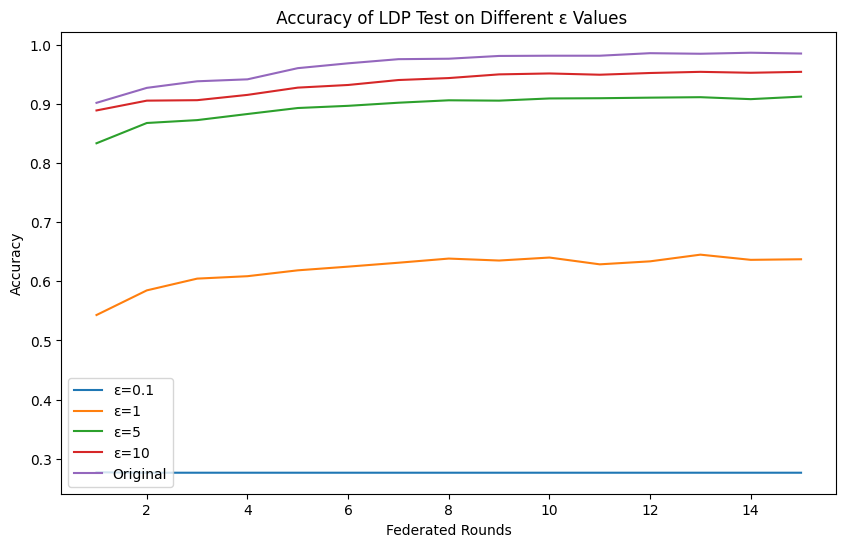

'\nglobal_accuracy_centralised = history.metrics_distributed ["accuracy"]\nround = [data[0] for data in global_accuracy_centralised]\nacc = [100.0 * data[1] for data in global_accuracy_centralised]\n'

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for eps, history_data in all_histories.items():
    # Extracting round numbers and corresponding accuracies from tuples
    accuracies = [acc[1] for acc in history_data.metrics_distributed['accuracy']]  # Correctly accessing the 'accuracy' key in the history dictionary
    rounds = [round[0] for round in history_data.metrics_distributed['accuracy']]  # Extract round numbers if needed for x-axis

    label = 'Original' if eps == float('inf') else f'ε={eps}'
    plt.plot(rounds, accuracies, label=label)  # Ensure rounds are used as the x-axis values

plt.title(' Accuracy of LDP Test on Different ε Values')
plt.xlabel('Federated Rounds')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
'''
global_accuracy_centralised = history.metrics_distributed ["accuracy"]
round = [data[0] for data in global_accuracy_centralised]
acc = [100.0 * data[1] for data in global_accuracy_centralised]
'''

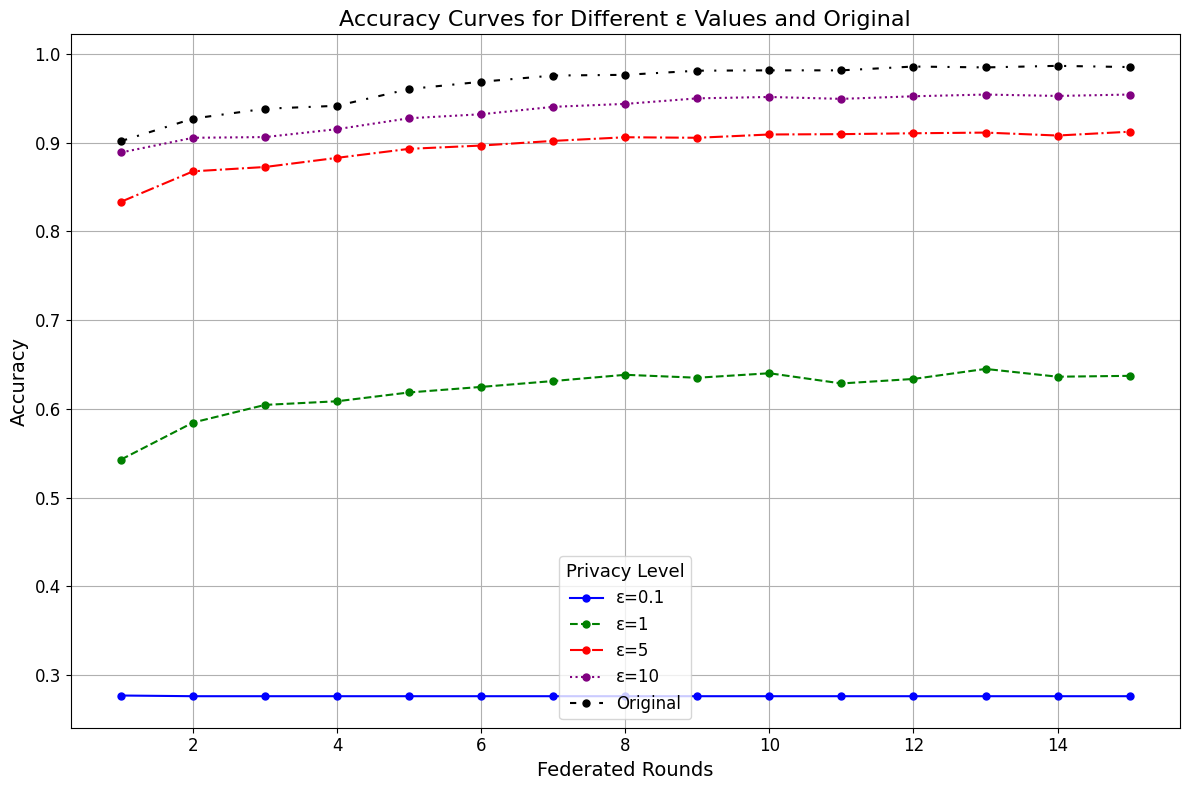

In [ ]:
import matplotlib.pyplot as plt

# Setting up a nice color palette and line styles
colors = ['blue', 'green', 'red', 'purple', 'black']
line_styles = ['-', '--', '-.', ':', (0, (3, 5, 1, 5))]

plt.figure(figsize=(12, 8))  # Slightly larger figure size for better visibility
for i, (eps, history_data) in enumerate(all_histories.items()):
    # Extracting round numbers and corresponding accuracies from tuples
    accuracies = [acc[1] for acc in history_data.metrics_distributed['accuracy']]
    rounds = [round[0] for round in history_data.metrics_distributed['accuracy']]

    label = 'Original' if eps == float('inf') else f'ε={eps}'
    plt.plot(rounds, accuracies, label=label, color=colors[i % len(colors)], linestyle=line_styles[i % len(line_styles)], marker='o', markersize=5)

plt.title('Accuracy Curves for Different ε Values and Original', fontsize=16)
plt.xlabel('Federated Rounds', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(fontsize=12)  # Larger font size for ticks
plt.yticks(fontsize=12)
plt.legend(title='Privacy Level', title_fontsize='13', fontsize='12')
plt.grid(True)
plt.tight_layout()  # Adjusts plot parameters for better layout
plt.show()
